(original)

# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 


## Load packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

## Plots setup

In [74]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 800
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

## Load dataset

TODO: INSERT NEW DF WITH 200 X_test:

In [3]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
df_for_random = df.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF

In [4]:
df_for_random

Unnamed: 0  CR_S11  CC_S11  ENG_S11  HI_GRADE_AVG  GENDER_bin  \
0          11423      63      65       95     74.333333           1   
1           8153      78      73       74     75.000000           0   
2          12100      72      87       65     74.666667           0   
3           1499      36      48       59     47.666667           0   
4           7670      57      56       72     61.666667           0   
...          ...     ...     ...      ...           ...         ...   
4091        6782      64      67       55     62.000000           0   
4092        2544      54      34       58     48.666667           1   
4093        5419      77      73       78     76.000000           1   
4094        7810      71      70       59     66.666667           0   
4095        3467      62      61       57     60.000000           1   

      STRATUM_0  STRATUM_Stratum_1  STRATUM_Stratum_2  STRATUM_Stratum_3  \
0             0                  0                  0                  0   
1             0                  1                  0                  0   
2             0                  0                  0                  1   
3             0                  1                  0                  0   
4             0                  0                  0                  0   
...         ...                ...                ...                ...   
4091          0                  0                  1                  0   
4092          0                  0                  0                  1   
4093          0                  0                  0                  1   
4094          0                  0                  0                  1   
4095          0                  1                  0                  0   

      STRATUM_Stratum_4  STRATUM_Stratum_5  STRATUM_Stratum_6  \
0                     1                  0                  0   
1                     0                  0                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     1                  0                  0   
...                 ...                ...                ...   
4091                  0                  0                  0   
4092                  0                  0                  0   
4093                  0                  0                  0   
4094                  0                  0                  0   
4095                  0                  0                  0   

      SCHOOL_TYPE_ACADEMIC  SCHOOL_TYPE_Not_apply  SCHOOL_TYPE_TECHNICAL  \
0                        1                      0                      0   
1                        1                      0                      0   
2                        0                      0                      0   
3                        0                      0                      1   
4                        1                      0                      0   
...                    ...                    ...                    ...   
4091                     0                      0                      0   
4092                     1                      0                      0   
4093                     0                      0                      0   
4094                     0                      0                      0   
4095                     0                      0                      0   

      SCHOOL_TYPE_TECHNICAL/ACADEMIC  SCHOOL_NAT_PRIVATE  SCHOOL_NAT_PUBLIC  \
0                                  0                   1                  0   
1                                  0                   0                  1   
2                                  1                   0                  1   
3                                  0                   0                  1   
4                                  0                   1                  0   
...                              ...                 ...                

## Mergesort ranker

In [5]:
# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

In [6]:
# dfs_test_use =  X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})


In [7]:
# MERGESORT HERUNDER PÅ BIG 
X_test_y_test_FULL = pd.DataFrame()
dfs_test_use_temp=dfs_test_use.copy()

for i in range(200):
    dfs_test_use_temp[i]= dfs_test_use_temp[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use_temp[i]= dfs_test_use_temp[i].reset_index()

    data_value_counts_gen = []
    
    for j in range(1,len(dfs_test_use_temp[i])+1):
        data_value_counts_gen.append(np.array([dfs_test_use_temp[i]["4"][:j].value_counts(normalize=True)]))
    dfs_test_use_temp[i]["value_counts_col_GENDER"] = data_value_counts_gen

    data_entropy = []
    for k in range(len(dfs_test_use_temp[i])):
        data_entropy.append(-(dfs_test_use_temp[i]["value_counts_col_GENDER"][k]*np.log2(dfs_test_use_temp[i]["value_counts_col_GENDER"][k])).sum())
   
  
    dfs_test_use_temp[i]["entropy_col_GENDER"] = data_entropy

    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use_temp[i])


X_test_y_test_FULL.index.names = ['INDEXES']


df_sort_BIG =X_test_y_test_FULL

In [8]:
#Mean gender entropy
df_sort_BIG_mean =  df_sort_BIG.groupby('INDEXES').mean()
#df_sort_BIG_mean["intr_col_entropy"] = df_sort_BIG_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
df_sort_BIG_std =  df_sort_BIG.groupby('INDEXES').std()/np.sqrt(200)
#df_sort_BIG_std["incr_col_entropy"] = df_sort_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG_mean["incr_half_std"] = 0.5*df_sort_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_sort_BIG_mean["lower_std"] = df_sort_BIG_mean["entropy_col_GENDER"] - df_sort_BIG_mean["incr_half_std"]
df_sort_BIG_mean["upper_std"] = df_sort_BIG_mean["entropy_col_GENDER"] + df_sort_BIG_mean["incr_half_std"]


In [9]:
df_sort_BIG_mean

index  Unnamed: 0       0       1       2          3      4  \
INDEXES                                                                     
0        409418.135    7014.755  83.050  98.630  95.035  97.505000  0.650   
1        409661.005    6354.085  87.710  95.455  93.095  95.333333  0.250   
2        409545.750    5463.810  87.970  93.610  91.795  93.988333  0.155   
3        409580.375    6322.270  87.815  91.660  90.530  92.950000  0.165   
4        409435.265    6784.360  86.715  91.185  90.135  92.186667  0.170   
...             ...         ...     ...     ...     ...        ...    ...   
4091     409575.175    6736.890  46.795  32.785  36.730  36.918333  0.330   
4092     409729.180    6617.330  47.925  33.585  36.575  36.475000  0.320   
4093     409727.820    6197.615  48.350  33.825  34.695  35.766667  0.350   
4094     409682.320    5002.900  49.695  32.350  32.445  34.128333  0.180   
4095     409582.640    2971.080  49.180  31.550  21.040  30.661667  0.075   

           5      6      7      8      9     10     11     12   13     14  \
INDEXES                                                                     
0        0.0  0.000  0.010  0.195  0.320  0.425  0.050  0.990  0.0  0.000   
1        0.0  0.000  0.045  0.300  0.035  0.445  0.175  0.950  0.0  0.000   
2        0.0  0.000  0.120  0.380  0.130  0.180  0.190  0.875  0.0  0.000   
3        0.0  0.000  0.100  0.390  0.215  0.085  0.210  0.865  0.0  0.000   
4        0.0  0.000  0.080  0.420  0.320  0.050  0.130  0.875  0.0  0.000   
...      ...    ...    ...    ...    ...    ...    ...    ...  ...    ...   
4091     0.0  0.515  0.280  0.205  0.000  0.000  0.000  0.595  0.0  0.005   
4092     0.0  0.575  0.325  0.100  0.000  0.000  0.000  0.630  0.0  0.010   
4093     0.0  0.600  0.360  0.040  0.000  0.000  0.000  0.655  0.0  0.010   
4094     0.0  0.515  0.465  0.020  0.000  0.000  0.000  0.620  0.0  0.000   
4095     0.0  0.340  0.660  0.000  0.000  0.000  0.000  0.570  0.0  0.000   

            15     16     17         18  entropy_col_GENDER  incr_half_std  \
INDEXES                                                                      
0        0.010  0.990  0.010  97.633333            0.000000       0.000000   
1        0.050  0.950  0.050  96.348333            0.580000       0.017494   
2        0.125  0.870  0.130  96.215000            0.739228       0.012896   
3        0.135  0.860  0.140  96.703333            0.763654       0.010642   
4        0.125  0.880  0.120  95.346667            0.744615       0.010164   
...        ...    ...    ...        ...                 ...            ...   
4091     0.400  0.290  0.710  21.431667            0.974650       0.000113   
4092     0.360  0.300  0.700  17.973333            0.974638       0.000113   
4093     0.335  0.275  0.725  15.211667            0.974632       0.000113   
4094     0.380  0.285  0.715  16.851667            0.974601       0.000113   
4095     0.430  0.105  0.895  23.715000            0.974557       0.000113   

         lower_std  upper_std  
INDEXES                        
0         0.000000   0.000000  
1         0.562506   0.597494  
2         0.726333   0.752124  
3         0.753012   0.774296  
4         0.734451   0.754780  
...            ...        ...  
4091      0.974537   0.974763  
4092      0.974525   0.974752  
4093      0.974518   0.974745  
4094      0.974488   0.974714  
4095      0.974443   0.974670  

[4096 rows x 25 columns]

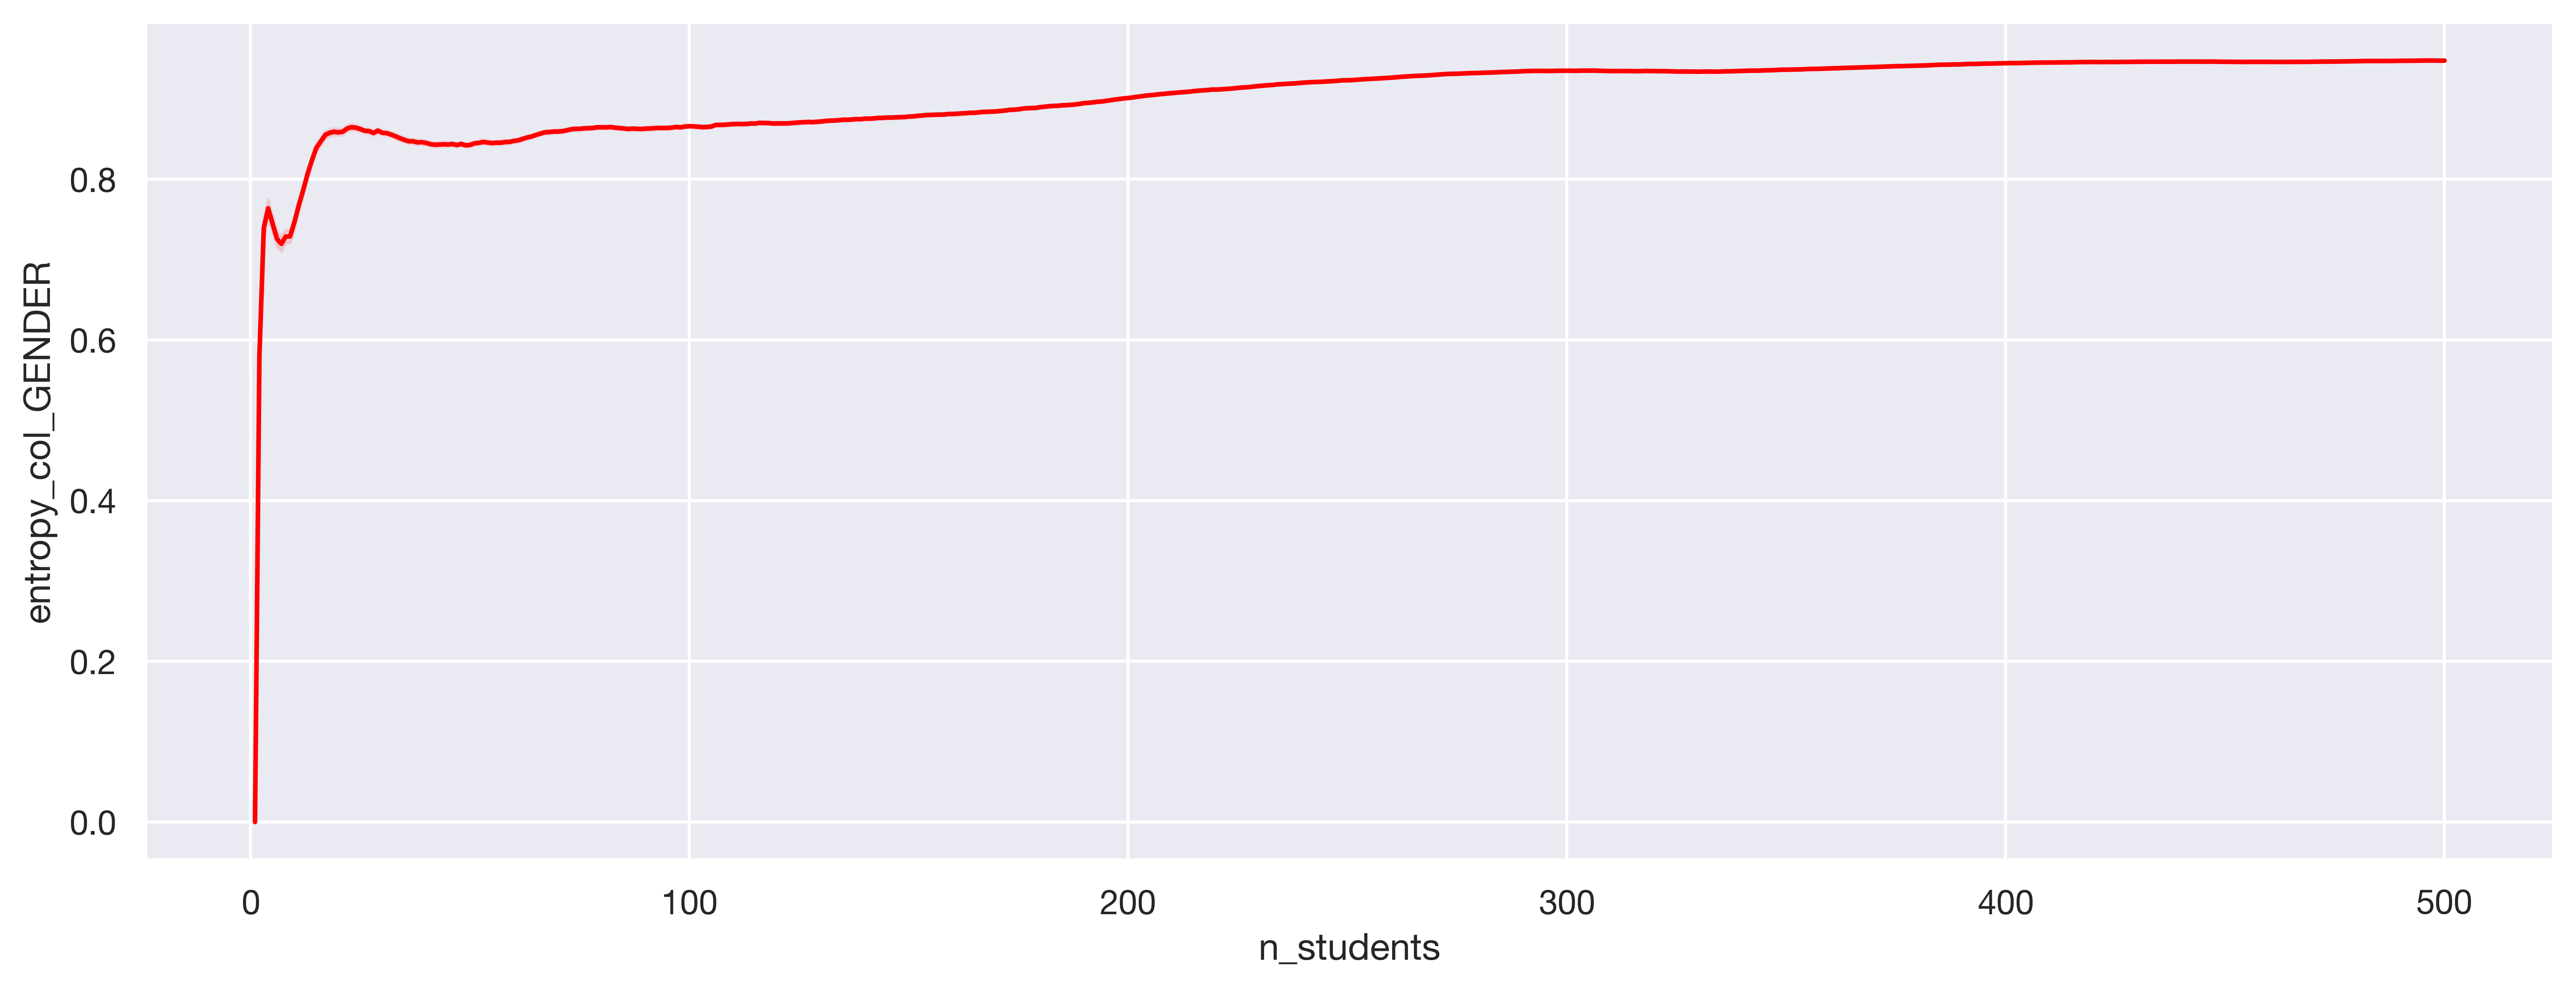

In [10]:
#n students cumsum
df_sort_BIG_mean["n_students"] = range(1,len(df_sort_BIG_mean)+1)

sns.lineplot(data=df_sort_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[0:500], alpha=0.1, color="red")
plt.show()

## Gendersort ranker

In [11]:
#Gendersort all - GAB

# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

X_test_y_test_GENDER = pd.DataFrame()


 
def gender_mergesort_BIG(df):
    
    dfs_test_use = df #= X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    
    #gender_df_BIG_func = pd.DataFrame()
    X_test_y_test_GENDER = pd.DataFrame()
 
    for i in range(len(dfs_test_use)):
        sorted_with_gender = pd.DataFrame()
        FEMALES = pd.DataFrame()
        MALES = pd.DataFrame()
        fem = dfs_test_use[i][dfs_test_use[i]['4'] != 0] #'4' = Gender_bins
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]

        fem = fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index() #'3' = HI_AVG_GPA
        mal = mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()

        FEMALES = FEMALES.append(fem)
        MALES=MALES.append(mal)
        
        
        FEMALES.index.names = ['INDEXES']
        MALES.index.names = ['INDEXES']

        if FEMALES['3'].max() > MALES['3'].max():
            sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
        else: 
            sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()
            
        
        #gender_df_BIG_func=gender_df_BIG_func.append(sorted_with_gender)
        #print(len(gender_df_BIG_func), "BIG")
        

        data_value_counts_gen = []

        for k in range(1,len(sorted_with_gender)+1):
            data_value_counts_gen.append(np.array([sorted_with_gender["4"][:k].value_counts(normalize=True)]))
        sorted_with_gender["value_counts_col_GENDER"] = data_value_counts_gen

        data_entropy = []
        for l in range(len(sorted_with_gender)):
            data_entropy.append(-(sorted_with_gender["value_counts_col_GENDER"].iloc[l]*np.log2(sorted_with_gender["value_counts_col_GENDER"].iloc[l])).sum())
        sorted_with_gender["entropy_col_GENDER"] = data_entropy
        
        #append each i df to big df
        X_test_y_test_GENDER = X_test_y_test_GENDER.append(sorted_with_gender)
        #print(len(X_test_y_test_GENDER))
        
        
    return X_test_y_test_GENDER.reset_index()
        

In [12]:
gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


In [13]:
#GENDER ranker

#CMA gender entropy
gender_df_BIG_mean =  gender_df_BIG.groupby('INDEXES').mean()
#gender_df_BIG_mean["incr_col_entropy"] = gender_df_BIG_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
gender_df_BIG_std =  gender_df_BIG.groupby('INDEXES').std()/np.sqrt(200)
#gender_df_BIG_std["incr_col_entropy"] = gender_df_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
gender_df_BIG_mean["incr_half_std"] = 0.5*gender_df_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
gender_df_BIG_mean["lower_std"] = gender_df_BIG_mean["entropy_col_GENDER"] - gender_df_BIG_mean["incr_half_std"]
gender_df_BIG_mean["upper_std"] = gender_df_BIG_mean["entropy_col_GENDER"] + gender_df_BIG_mean["incr_half_std"]


#nstudents
gender_df_BIG_mean["n_students"] = range(1,len(gender_df_BIG_mean)+1)


In [14]:
gender_df_BIG_mean

index   Unnamed: 0          0          1          2  \
INDEXES                                                                
0        409482.865000  6394.977500  84.637500  97.015000  92.980000   
1        409600.992500  6203.270000  85.852500  92.887500  89.480000   
2        409422.692500  7058.092500  83.097500  88.577500  89.125000   
3        409626.807500  7754.730000  81.910000  86.360000  88.680000   
4        409650.952500  7671.382500  82.565000  84.602500  89.732500   
...                ...          ...        ...        ...        ...   
2482     402126.750000  4596.500000  52.500000  28.750000  35.500000   
2483     449260.000000  8486.333333  43.000000  33.666667  35.333333   
2484     450133.000000  7203.333333  49.000000  26.333333  38.666667   
2485     449168.666667  4882.666667  46.333333  32.000000  31.333333   
2486     298191.000000  2086.000000  51.500000  34.500000  26.000000   

                 3    4    5         6         7         8       9      10  \
INDEXES                                                                      
0        95.911667  0.5  0.0  0.000000  0.022500  0.277500  0.2000  0.4125   
1        92.818333  0.5  0.0  0.000000  0.077500  0.422500  0.1450  0.2050   
2        91.177500  0.5  0.0  0.000000  0.052500  0.492500  0.1750  0.1150   
3        90.283333  0.5  0.0  0.000000  0.040000  0.447500  0.2200  0.1500   
4        89.553333  0.5  0.0  0.000000  0.042500  0.407500  0.2075  0.2050   
...            ...  ...  ...       ...       ...       ...     ...     ...   
2482     36.333333  0.0  0.0  0.250000  0.500000  0.250000  0.0000  0.0000   
2483     36.555556  0.0  0.0  0.666667  0.333333  0.000000  0.0000  0.0000   
2484     35.666667  0.0  0.0  0.333333  0.333333  0.333333  0.0000  0.0000   
2485     33.666667  0.0  0.0  0.000000  1.000000  0.000000  0.0000  0.0000   
2486     31.166667  0.0  0.0  0.500000  0.500000  0.000000  0.0000  0.0000   

             11        12   13   14        15      16      17         18  \
INDEXES                                                                    
0        0.0875  0.977500  0.0  0.0  0.022500  0.9600  0.0400  96.825833   
1        0.1500  0.917500  0.0  0.0  0.082500  0.8525  0.1475  96.704167   
2        0.1650  0.915000  0.0  0.0  0.085000  0.8950  0.1050  96.073333   
3        0.1425  0.922500  0.0  0.0  0.077500  0.9400  0.0600  94.632500   
4        0.1375  0.912500  0.0  0.0  0.087500  0.9625  0.0375  93.799167   
...         ...       ...  ...  ...       ...     ...     ...        ...   
2482     0.0000  0.750000  0.0  0.0  0.250000  0.7500  0.2500  22.250000   
2483     0.0000  0.333333  0.0  0.0  0.666667  0.0000  1.0000  19.000000   
2484     0.0000  1.000000  0.0  0.0  0.000000  1.0000  0.0000  16.444444   
2485     0.0000  1.000000  0.0  0.0  0.000000  0.0000  1.0000  12.222222   
2486     0.0000  0.000000  0.0  0.0  1.000000  0.0000  1.0000  27.500000   

         entropy_col_GENDER  incr_half_std  lower_std  upper_std  n_students  
INDEXES                                                                       
0                  0.500000       0.017700   0.482300   0.517700           1  
1                  0.959148       0.001446   0.957702   0.960594           2  
2                  0.985475       0.000514   0.984961   0.985989           3  
3                  0.992614       0.000261   0.992353   0.992876           4  
4                  0.995538       0.000158   0.995380   0.995696           5  
...                     ...            ...        ...        ...         ...  
2482               0.966953       0.000006   0.966947   0.966959        2483  
2483               0.966808       0.000002   0.966806   0.966810        2484  
2484               0.966748       0.000002   0.966746   0.966750        2485  
2485               0.966688       0.000002   0.966686   0.966690        2486  
2486               0.966597       0.000000   0.966597   0.966597        2487  

[2487 rows x 26 columns]

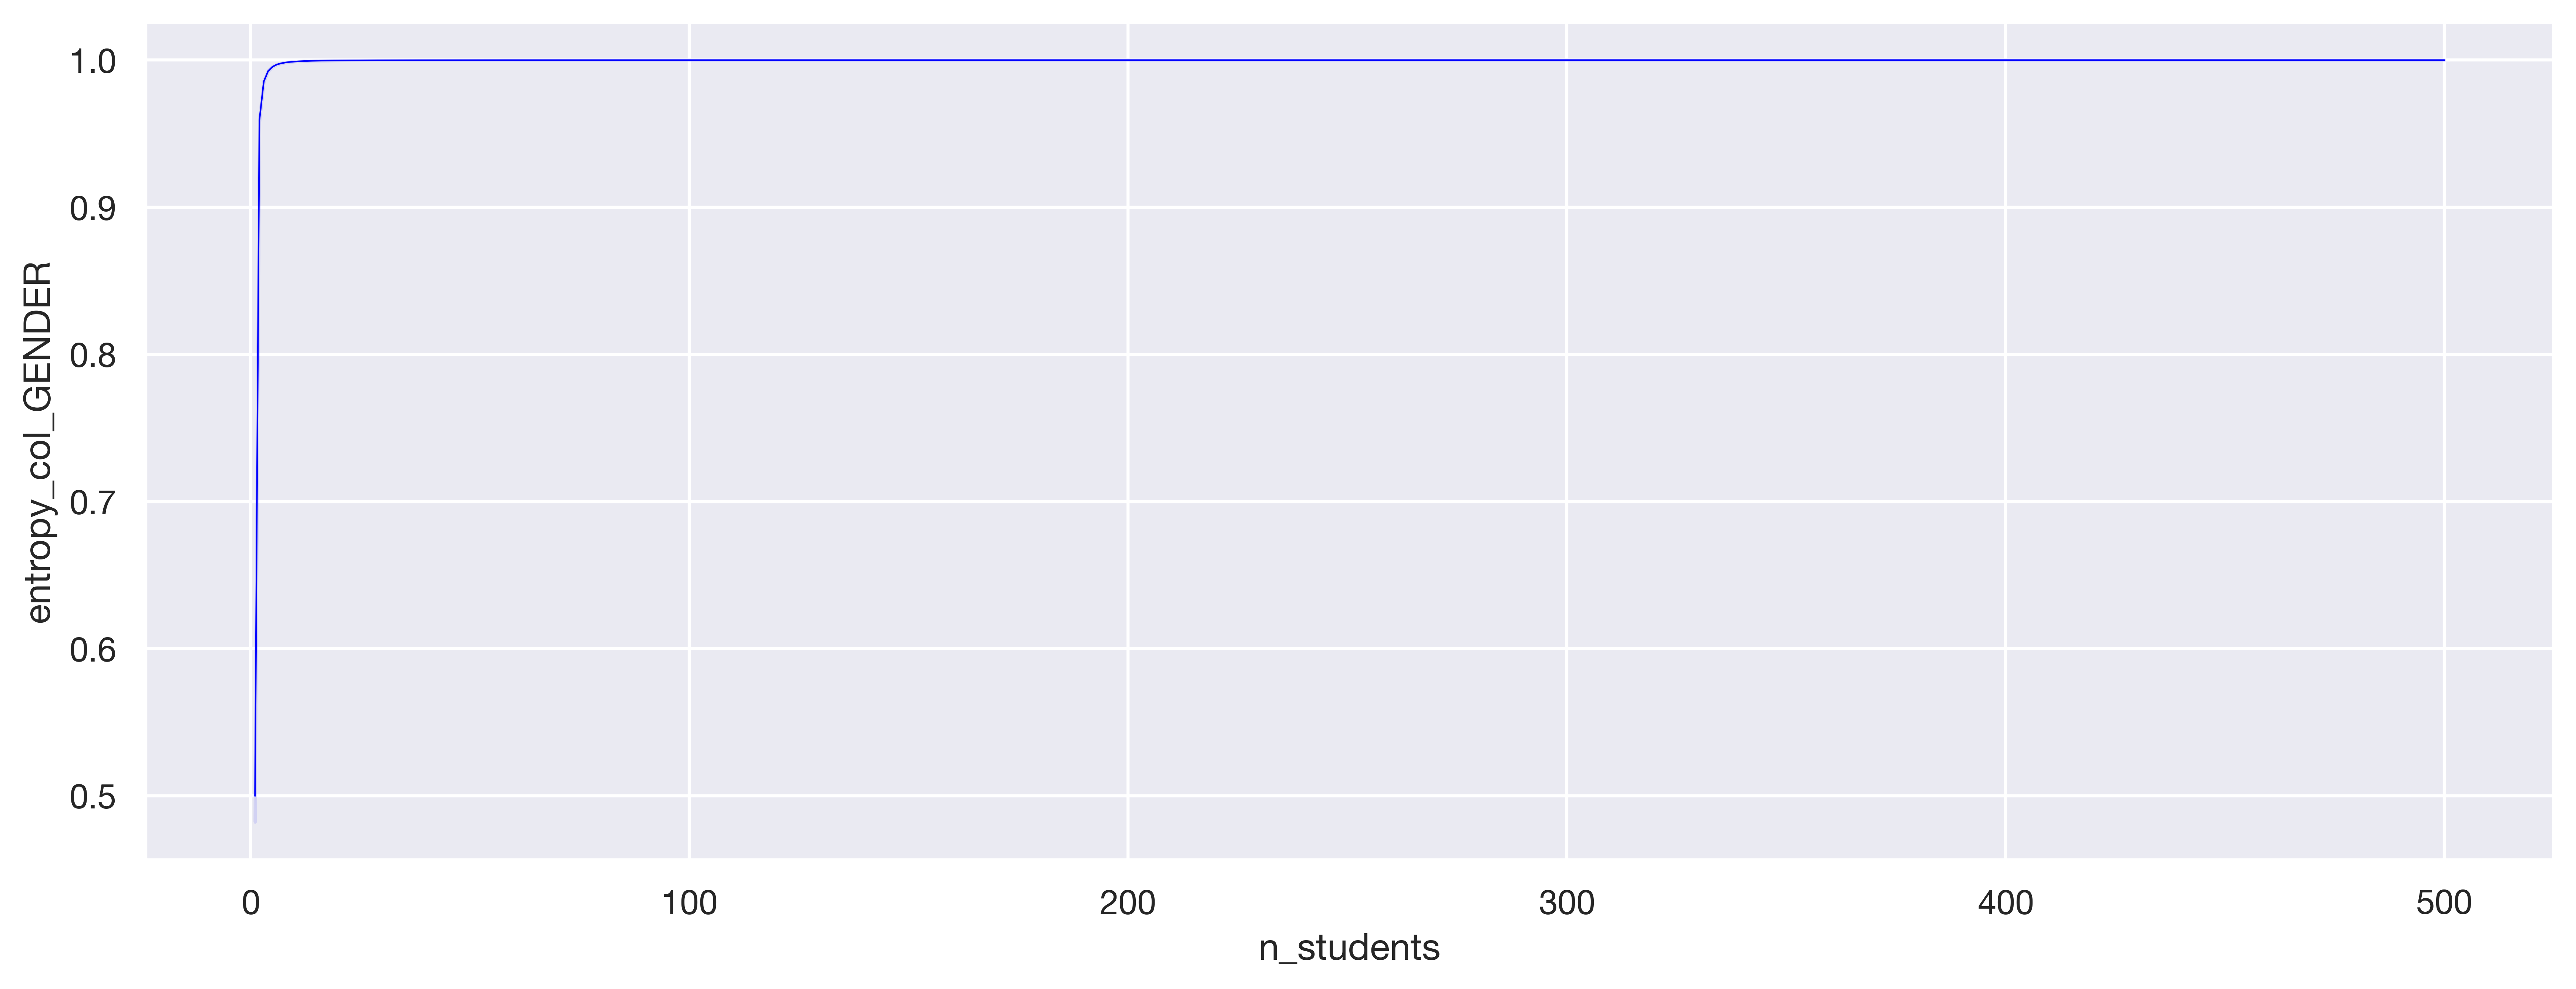

In [15]:
## PLOT

#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")
# sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")

# big gender df
#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.1)
sns.lineplot(data=gender_df_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[0:500], alpha=0.1, color="blue")
plt.show()

## Plain XGBoost 

In [16]:
df_PLAIN_TWO_NY = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
indexs = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()
#apply new column of cumsum+1

#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_PLAIN_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_PLAIN_TWO_NY_use[df_PLAIN_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]

In [17]:
df_PLAIN_TWO_NY_use["Gender_bins"][2]#[:500].value_counts()
GUDF = pd.read_csv('GUDF.csv')

Splitte_PLAIN = np.array_split(df_PLAIN_TWO_NY_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op
GUDF['Idx'] = GUDF['Unnamed: 0'] 


In [18]:
Splitte_PLAIN[1]["Unnamed: 0"].max()

499

In [19]:
pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [20]:
PLAIN_USE_VALUE_COUNTS.iloc[[500,510, 1000,1010]]

value_counts_col_GENDER
500                     [[]]
510                  [[1.0]]
1000                    [[]]
1010            [[0.8, 0.2]]

In [21]:
#append value counts to dataframe
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()

In [22]:
df_PLAIN_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER
df_PLAIN_TWO_NY_use

index  Unnamed: 0    Idx  Gender_bins      Preds  \
0           0           0   7490            1  92.565254   
1           1           1  12018            1  92.565254   
2           2           2  11864            1  92.565254   
3           3           3  12016            0  92.565254   
4           4           4   1089            0  92.477142   
...       ...         ...    ...          ...        ...   
99995  815599         495  12144            0  84.307159   
99996  815600         496    169            0  84.275749   
99997  815601         497   9616            0  84.275749   
99998  815602         498  11648            0  84.181122   
99999  815603         499   6901            1  84.133453   

                           value_counts_col_GENDER  
0                                             [[]]  
1                                          [[1.0]]  
2                                          [[1.0]]  
3                                          [[1.0]]  
4                                   [[0.75, 0.25]]  
...                                            ...  
99995   [[0.6383838383838384, 0.3616161616161616]]  
99996  [[0.6391129032258065, 0.36088709677419356]]  
99997  [[0.6398390342052314, 0.36016096579476864]]  
99998  [[0.6405622489959839, 0.35943775100401604]]  
99999   [[0.6412825651302605, 0.3587174348697395]]  

[100000 rows x 6 columns]

In [23]:
df_PLAIN_TWO_NY_use

index  Unnamed: 0    Idx  Gender_bins      Preds  \
0           0           0   7490            1  92.565254   
1           1           1  12018            1  92.565254   
2           2           2  11864            1  92.565254   
3           3           3  12016            0  92.565254   
4           4           4   1089            0  92.477142   
...       ...         ...    ...          ...        ...   
99995  815599         495  12144            0  84.307159   
99996  815600         496    169            0  84.275749   
99997  815601         497   9616            0  84.275749   
99998  815602         498  11648            0  84.181122   
99999  815603         499   6901            1  84.133453   

                           value_counts_col_GENDER  
0                                             [[]]  
1                                          [[1.0]]  
2                                          [[1.0]]  
3                                          [[1.0]]  
4                                   [[0.75, 0.25]]  
...                                            ...  
99995   [[0.6383838383838384, 0.3616161616161616]]  
99996  [[0.6391129032258065, 0.36088709677419356]]  
99997  [[0.6398390342052314, 0.36016096579476864]]  
99998  [[0.6405622489959839, 0.35943775100401604]]  
99999   [[0.6412825651302605, 0.3587174348697395]]  

[100000 rows x 6 columns]

In [24]:
#get entropy of valuecounts for all rows
df_PLAIN_TWO_NY_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_PLAIN_TWO_NY_entropy_GENDER.append(-(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_PLAIN_TWO_NY_use["entropy_col_GENDER"] = df_PLAIN_TWO_NY_entropy_GENDER

In [25]:
#create entropy mean df and entropy std df
df_PLAIN_TWO_NY_ENTROPY = df_PLAIN_TWO_NY_use
df_PLAIN_TWO_NY_ENTROPY_std = df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_PLAIN_TWO_NY_ENTROPY_mean =  df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').mean()


In [26]:
df_PLAIN_TWO_NY_ENTROPY_std

index         Idx  Gender_bins     Preds  \
Unnamed: 0                                                    
0           16763.602477  208.021033     0.011067  0.030358   
1           16763.602477  232.239893     0.011067  0.030464   
2           16763.602477  232.084270     0.013891  0.030531   
3           16763.602477  208.647990     0.013028  0.030665   
4           16763.602477  225.152648     0.015450  0.030521   
...                  ...         ...          ...       ...   
495         16763.602477  249.954453     0.033459  0.026529   
496         16763.602477  262.281772     0.033580  0.026592   
497         16763.602477  259.172926     0.034225  0.026615   
498         16763.602477  245.541337     0.033459  0.026600   
499         16763.602477  272.141680     0.032929  0.026667   

            entropy_col_GENDER  
Unnamed: 0                      
0                     0.000000  
1                     0.000000  
2                     0.012093  
3                     0.014841  
4                     0.016828  
...                        ...  
495                   0.001112  
496                   0.001121  
497                   0.001126  
498                   0.001135  
499                   0.001137  

[500 rows x 5 columns]

### OBS: CMA entropy mean and CMA standard error

In [27]:
#df_PLAIN_TWO_NY_ENTROPY_mean["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_PLAIN_TWO_NY_ENTROPY_std["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_PLAIN_TWO_NY_ENTROPY_mean["n_students"] = range(1,len(df_PLAIN_TWO_NY_ENTROPY_mean)+1)

# df_PLAIN_TWO_NY_ENTROPY_std[50:150]


df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"] = .5*df_PLAIN_TWO_NY_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_PLAIN_TWO_NY_ENTROPY_mean["lower_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] - df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]
df_PLAIN_TWO_NY_ENTROPY_mean["upper_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] + df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]






In [28]:
## MEAN Entropy
entr_plain = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_plain: ", entr_plain)

entr_plain:  0.9447026137942097


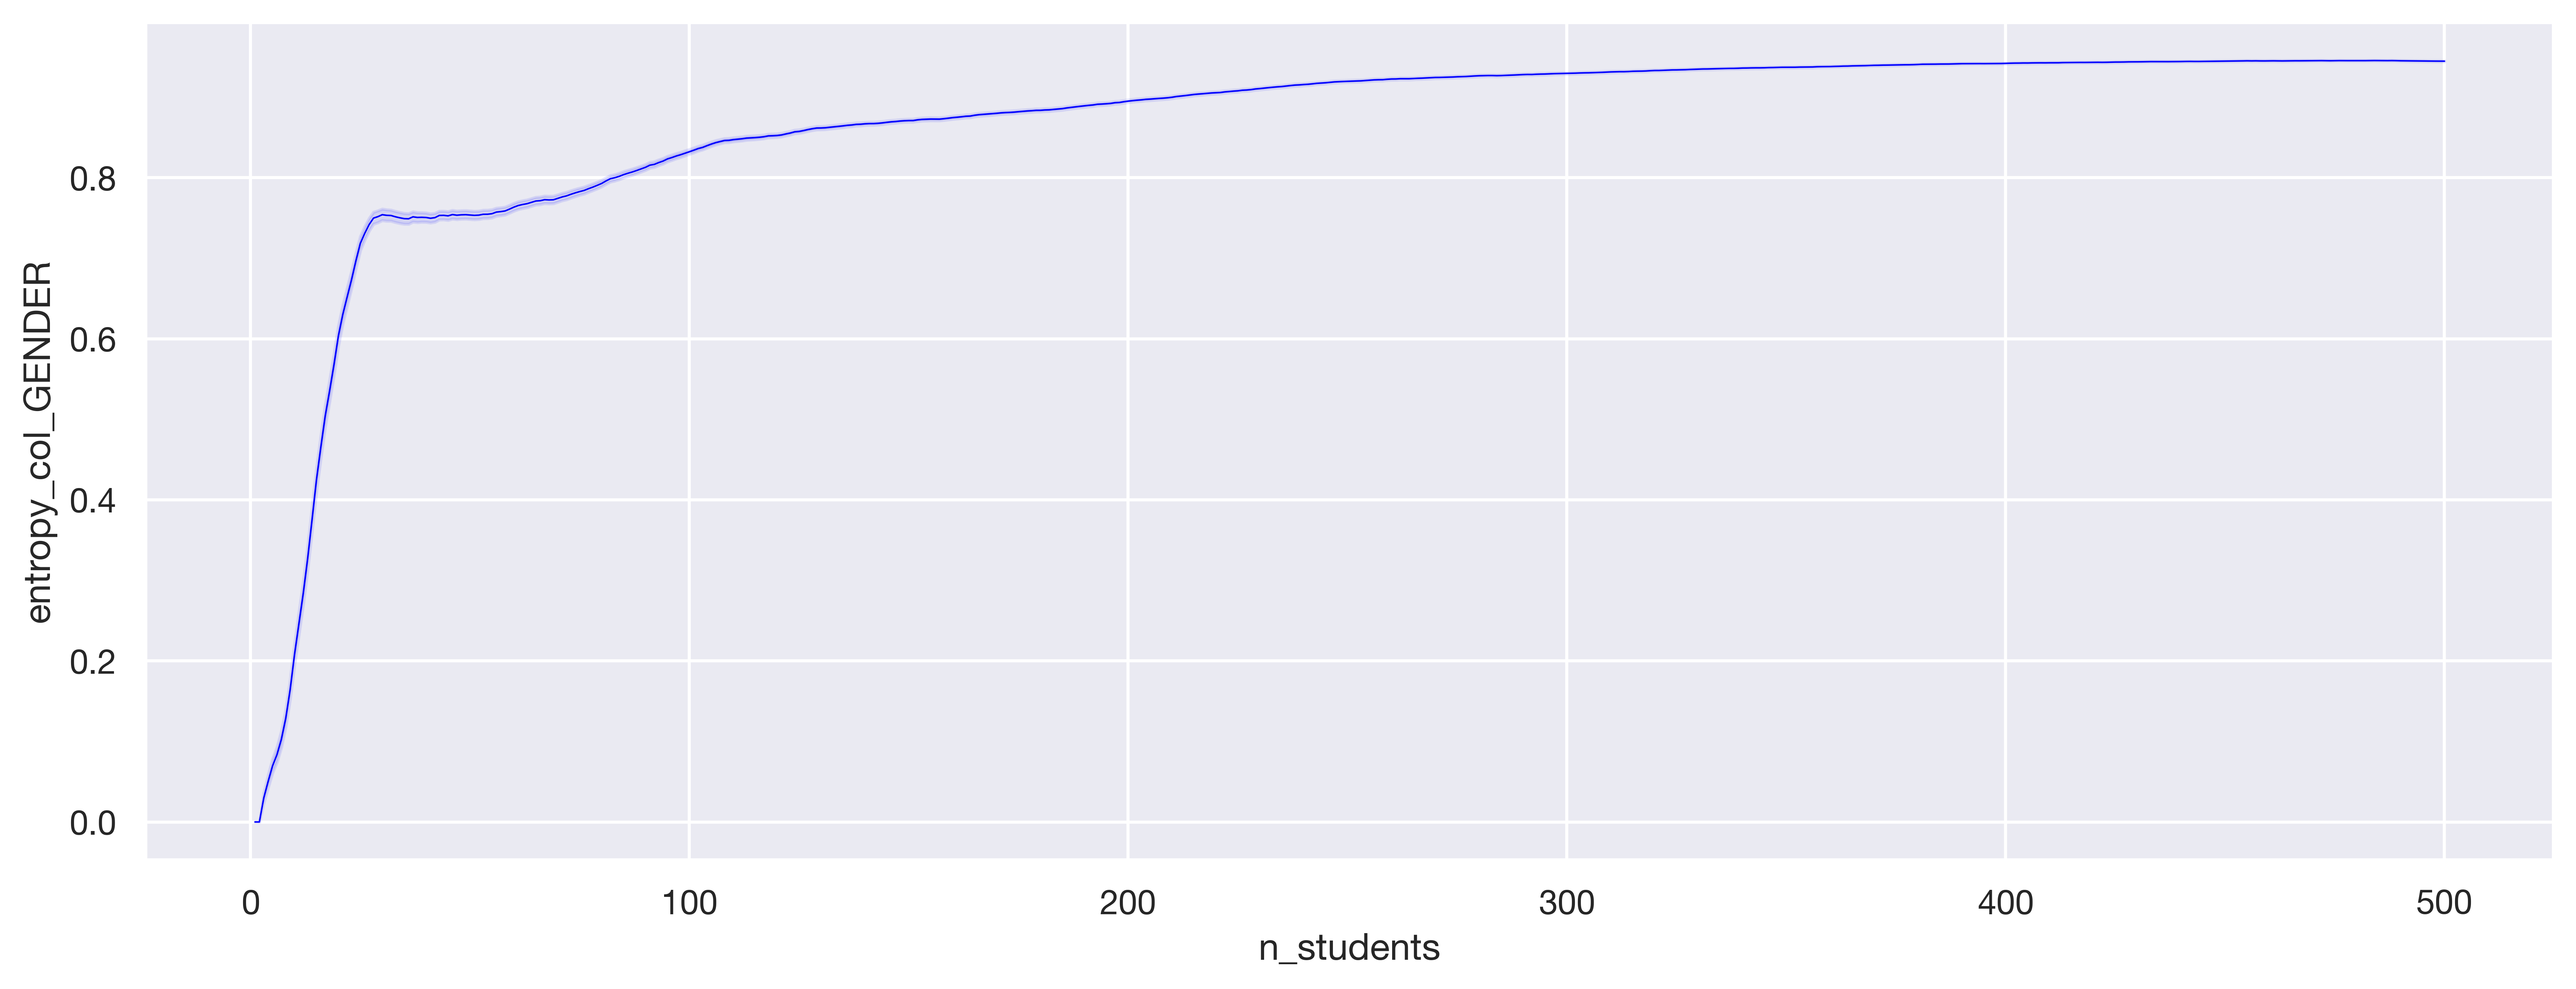

In [29]:
#sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="Unnamed: 0", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], alpha=0.1, color="blue")


## XGBoost w/o sensitive attributes

In [30]:
df_wo = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]
df_wo_use = df_wo_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_wo_use["Unnamed: 0"].unique():
    stds.append(df_wo_use[df_wo_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]

#split df
Splitte_PLAIN = np.array_split(df_wo_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op


In [31]:
pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [32]:
#append value counts to dataframe
df_wo_use = df_wo_use.reset_index()

df_wo_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


In [33]:
#get entropy of valuecounts for all rows
df_wo_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_wo_entropy_GENDER.append(-(df_wo_use["value_counts_col_GENDER"][i]*np.log2(df_wo_use["value_counts_col_GENDER"][i])).sum())    

df_wo_use["entropy_col_GENDER"] = df_wo_entropy_GENDER

#create entropy mean df and entropy std df
df_wo_ENTROPY = df_wo_use
df_wo_ENTROPY_std = df_wo_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_wo_ENTROPY_mean =  df_wo_ENTROPY.groupby('Unnamed: 0').mean()


In [34]:
#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
#df_wo_ENTROPY_mean["CMA_gender_entropy"] = df_wo_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_wo_ENTROPY_std["CMA_gender_entropy"] = df_wo_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_wo_ENTROPY_mean["n_students"] = range(1,len(df_wo_ENTROPY_mean)+1)


#create std error
df_wo_ENTROPY_mean["incr_half_std"] = .5*df_wo_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_wo_ENTROPY_mean["lower_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] - df_wo_ENTROPY_mean["incr_half_std"]
df_wo_ENTROPY_mean["upper_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] + df_wo_ENTROPY_mean["incr_half_std"]




In [35]:
## MEAN Entropy
entr_wo = df_wo_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_wo: ", entr_wo)

entr_wo:  0.9474517528779118


In [36]:

#df_WO_ENTROPY = df_wo_use
#df_WO_ENTROPY_std = df_WO_ENTROPY.groupby('Unnamed: 0').std()
#df_WO_ENTROPY_mean =  df_WO_ENTROPY.groupby('Unnamed: 0').mean()
# df_WO_ENTROPY_mean = df_WO_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
#df_WO_ENTROPY_mean["ENTROPY_KAT"] = df_WO_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
# sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")


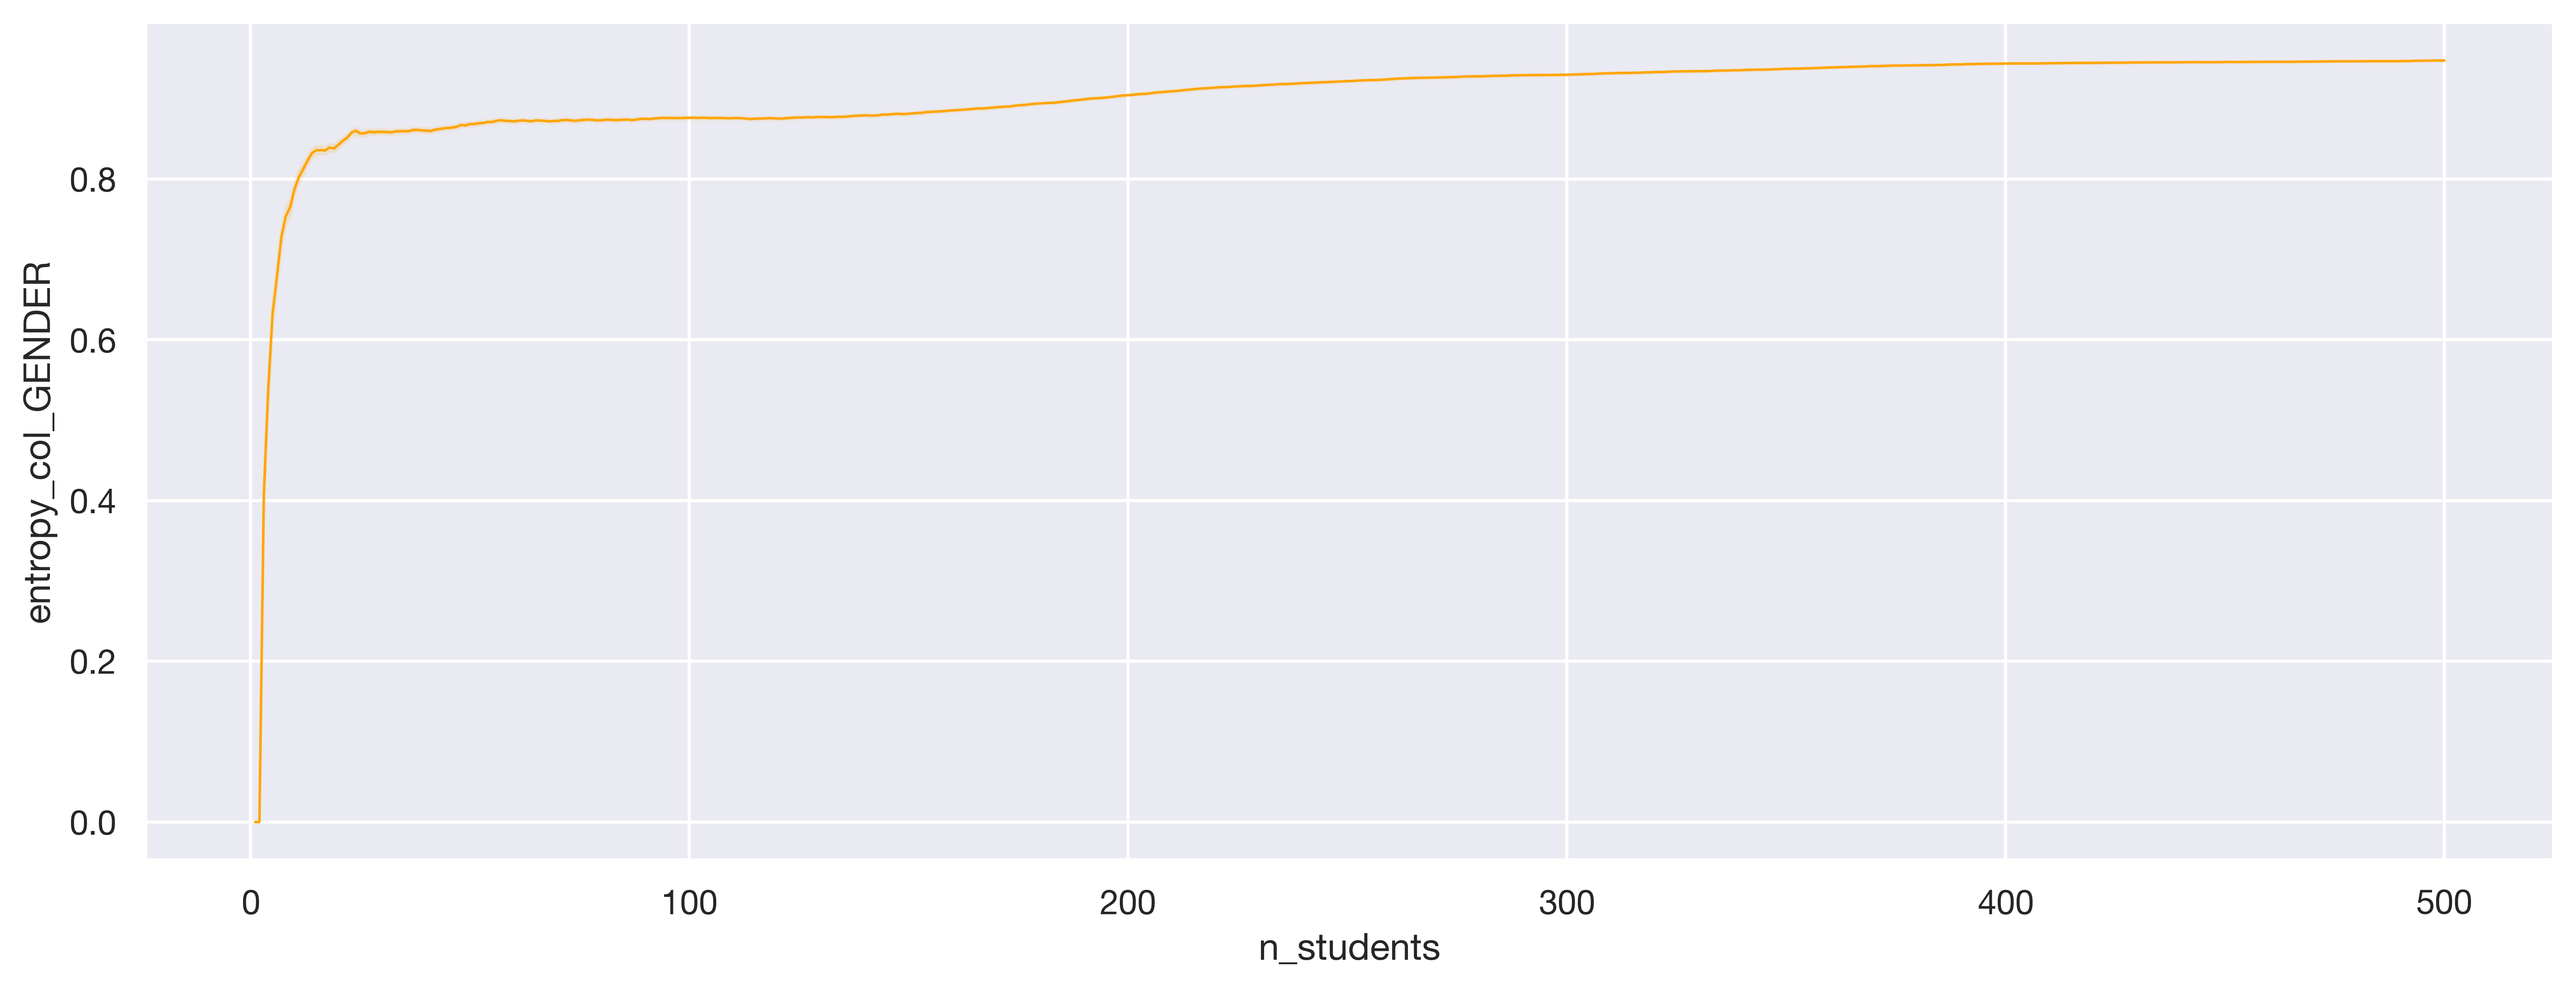

In [37]:
sns.lineplot(data=df_wo_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[:500], alpha=0.1, color="orange")


## Fairness enhanced Ranker 

In [38]:
df_FAIR_TWO_NY = pd.read_csv('re_ranked_199_NY.csv')
indexs = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_FAIR_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_FAIR_TWO_NY_use[df_FAIR_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.loc[df_FAIR_TWO_NY_use['Unnamed: 0'].isin(indexs)]


#split df
Splitte_PLAIN = np.array_split(df_FAIR_TWO_NY_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op


In [39]:
## Create entropy

pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


#append value counts to dataframe
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()

df_FAIR_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


#get entropy of valuecounts for all rows
df_fair_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_fair_entropy_GENDER.append(-(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_FAIR_TWO_NY_use["entropy_col_GENDER"] = df_fair_entropy_GENDER

#create entropy mean df and entropy std df
df_fair_ENTROPY = df_FAIR_TWO_NY_use
df_fair_ENTROPY_std = df_fair_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_fair_ENTROPY_mean =  df_fair_ENTROPY.groupby('Unnamed: 0').mean()


#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
df_fair_ENTROPY_mean["CMA_gender_entropy"] = df_fair_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

df_fair_ENTROPY_mean["n_students"] = range(1,len(df_fair_ENTROPY_mean)+1)


#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] + df_fair_ENTROPY_mean["incr_half_std"]


In [40]:
# SE for cum: 
df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["CMA_gender_entropy"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] + df_fair_ENTROPY_mean["incr_half_std"]


In [41]:
## MEAN Entropy
entr_fair = df_fair_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_fair: ", entr_fair)

entr_fair:  0.9673336121854237


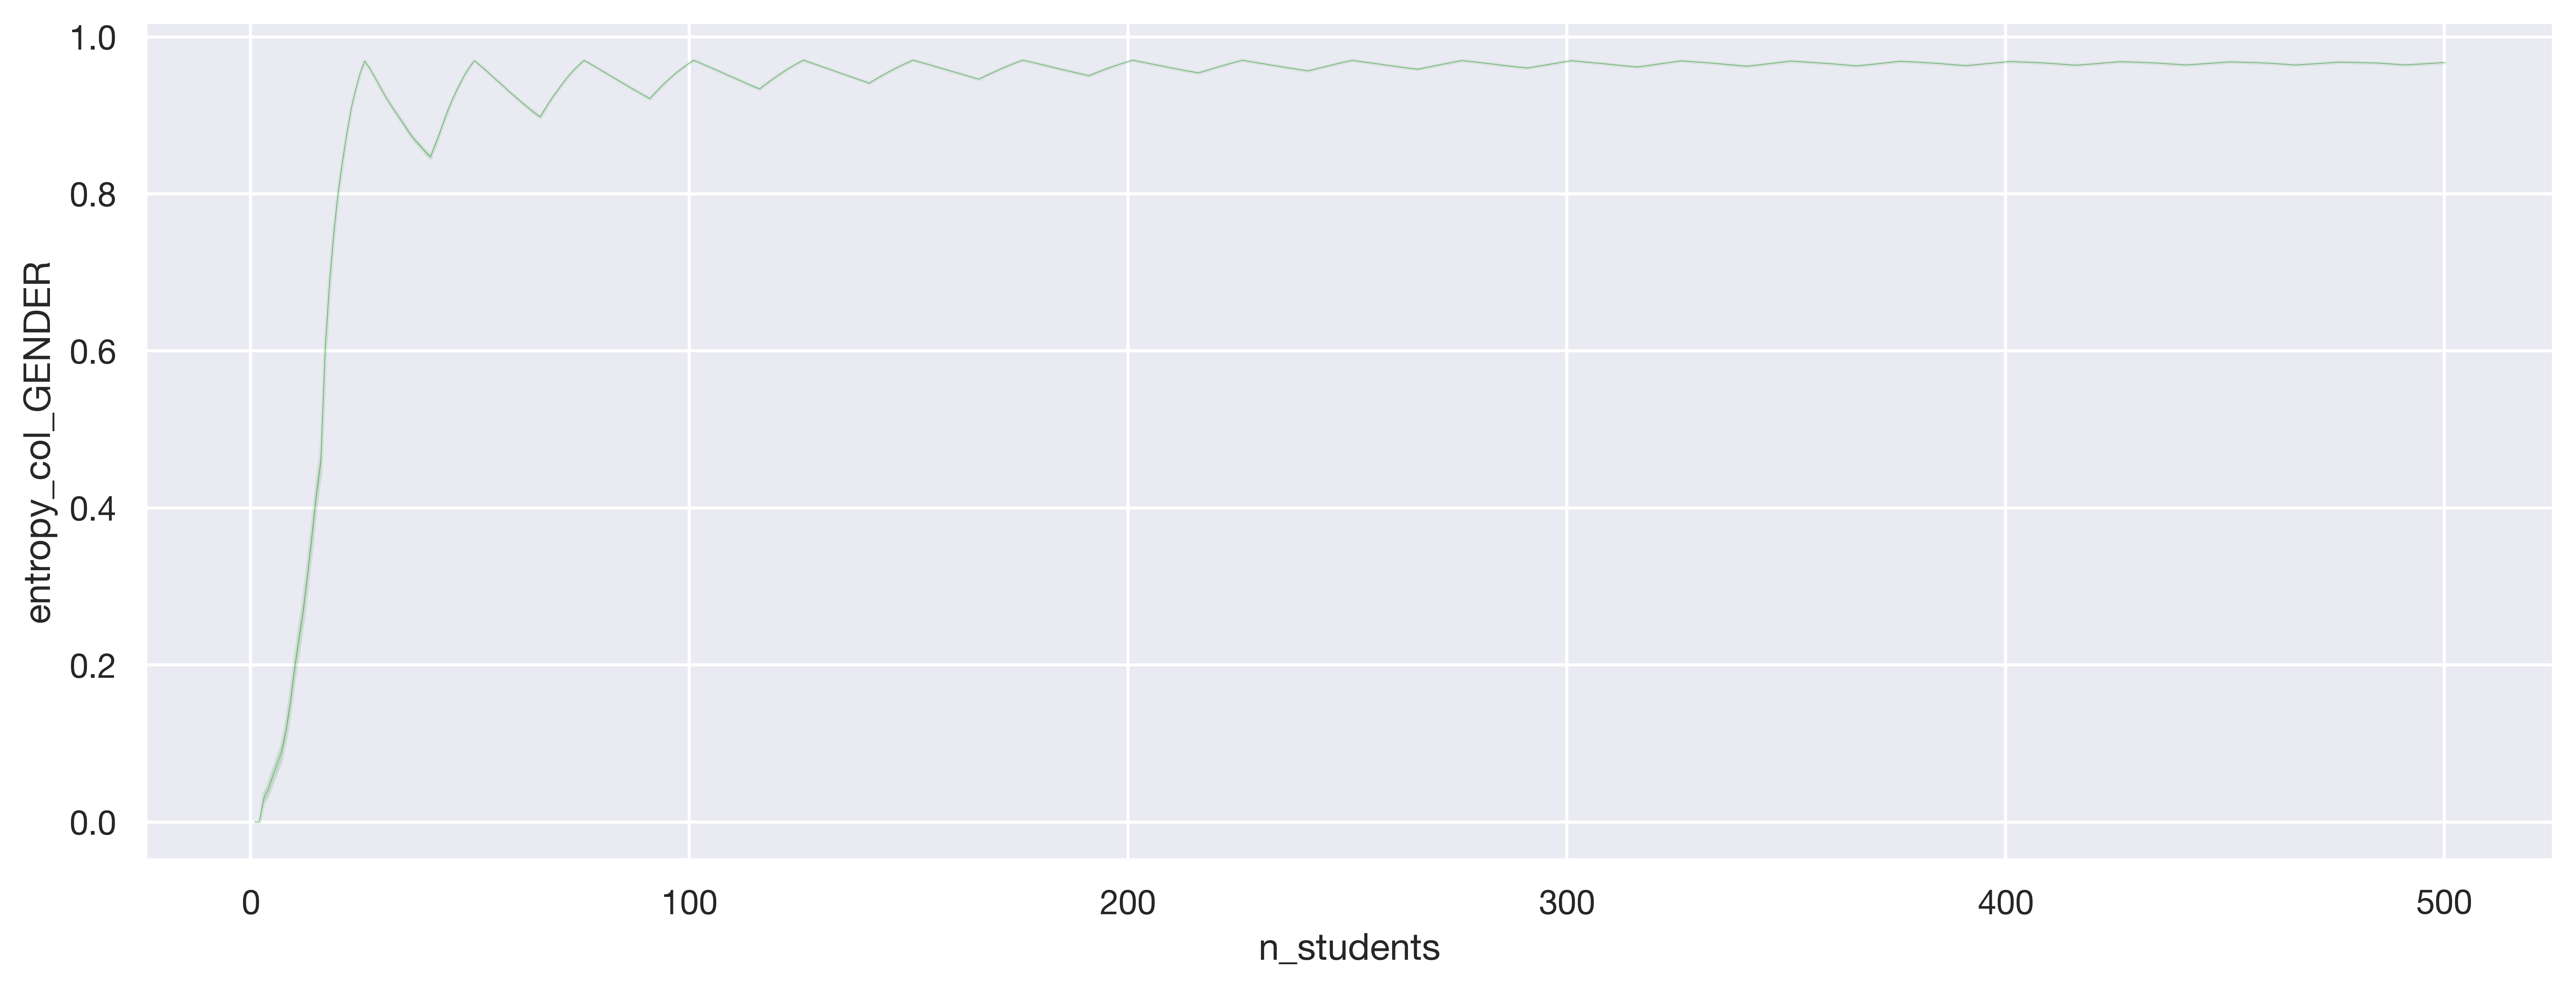

In [42]:
sns.lineplot(data=df_fair_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.1)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[:500], alpha=0.1, color="green")


In [43]:
df_fair_ENTROPY[:50]

level_0  index  Unnamed: 0      Idx  Gender_bins      Preds  Unnamed: 0.1  \
0         0      0           0  12016.0          0.0  92.565254           3.0   
1         1      1           1   7490.0          1.0  92.565254           0.0   
2         2      2           2  11864.0          1.0  92.565254           2.0   
3         3      3           3  12018.0          1.0  92.565254           1.0   
4         4      4           4   2607.0          0.0  92.477142           7.0   
5         5      5           5   4874.0          0.0  92.477142           9.0   
6         6      6           6   1089.0          0.0  92.477142           4.0   
7         7      7           7  12328.0          0.0  92.477142           5.0   
8         8      8           8  10992.0          1.0  92.477142           6.0   
9         9      9           9   8492.0          1.0  92.477142           8.0   
10       10     10          10   4900.0          0.0  92.430847          10.0   
11       11     11          11  11800.0          0.0  92.372017          11.0   
12       12     12          12  12063.0          0.0  92.195969          15.0   
13       13     13          13   8766.0          0.0  92.195969          13.0   
14       14     14          14  11651.0          0.0  92.195969          14.0   
15       15     15          15   6070.0          1.0  92.195969          12.0   
16       16     16          16   7510.0          0.0  92.090843          16.0   
17       17     17          17  12112.0          0.0  91.599686          17.0   
18       18     18          18  12028.0          0.0  91.588852          18.0   
19       19     19          19   2308.0          1.0  91.542557          19.0   
20       20     20          20  11260.0          1.0  91.455826          20.0   
21       21     21          21   7342.0          1.0  91.439011          21.0   
22       22     22          22   4293.0          0.0  91.429619          22.0   
23       23     23          23   8893.0          0.0  91.392715          24.0   
24       24     24          24   2648.0          0.0  91.314308          25.0   
25       25     25          25  10846.0          1.0  91.412064          23.0   
26       26     26          26   2648.0          0.0  91.314308          25.0   
27       27     27          27  11866.0          0.0  91.314308          26.0   
28       28     28          28   2137.0          0.0  91.307678          27.0   
29       29     29          29  11321.0          0.0  91.297295          28.0   
30       30     30          30   6179.0          0.0  91.297295          29.0   
31       31     31          31    637.0          0.0  91.297295          30.0   
32       32     32          32  11362.0          1.0  91.297295          31.0   
33       33     33          33  11868.0          0.0  91.277679          32.0   
34       34     34          34  12346.0          0.0  91.209183          33.0   
35       35     35          35   6145.0          0.0  91.209183          34.0   
36       36     36          36   8883.0          0.0  91.209183          36.0   
37       37     37          37  10363.0          1.0  91.209183          35.0   
38       38     38          38   4799.0          0.0  91.174652          37.0   
39       39     39          39  11861.0          1.0  91.174210          38.0   
40       40     40          40   9300.0          0.0  91.162888          39.0   
41       41     41          41   8905.0          0.0  91.129669          40.0   
42       42     42          42    118.0          0.0  91.085083          41.0   
43       43     43          43  10046.0          0.0  91.085083          42.0   
44       44     44          44  11230.0          1.0  90.979958          46.0   
45       45     45          45    622.0          1.0  90.979828          50.0   
46       46     46          46   5168.0          1.0  90.976944          51.0   
47       47     47          47   9055.0          1.0  90.933624          54.0   
48       48     48          48   70

In [44]:
pd.set_option("display.max_columns", None)
df_fair_ENTROPY_mean[20:60]


level_0    index       Idx  Gender_bins      Preds  Unnamed: 0.1  \
Unnamed: 0                                                                     
20          49770.0  49770.0  7586.275        0.795  91.983299        26.795   
21          49771.0  49771.0  7375.675        0.860  91.852864        30.510   
22          49772.0  49772.0  7741.120        0.860  91.685069        35.490   
23          49773.0  49773.0  7876.080        0.935  91.523514        39.835   
24          49774.0  49774.0  7542.200        0.935  91.371717        44.000   
25          49775.0  49775.0  7950.085        0.065  92.258621        18.455   
26          49776.0  49776.0  7919.950        0.035  92.184313        20.085   
27          49777.0  49777.0  7944.155        0.020  92.109302        22.000   
28          49778.0  49778.0  7532.820        0.020  92.034224        23.370   
29          49779.0  49779.0  7879.060        0.040  91.960222        24.750   
30          49780.0  49780.0  8017.240        0.080  91.888866        26.290   
31          49781.0  49781.0  7921.870        0.095  91.831979        27.580   
32          49782.0  49782.0  7588.100        0.090  91.763395        28.890   
33          49783.0  49783.0  7516.305        0.095  91.690353        30.115   
34          49784.0  49784.0  8032.245        0.060  91.648067        31.070   
35          49785.0  49785.0  7594.700        0.080  91.605734        32.340   
36          49786.0  49786.0  7750.745        0.125  91.558759        33.465   
37          49787.0  49787.0  8264.125        0.130  91.529940        34.520   
38          49788.0  49788.0  7546.540        0.115  91.501995        35.560   
39          49789.0  49789.0  7817.185        0.150  91.471376        36.510   
40          49790.0  49790.0  7321.935        0.660  91.217408        47.925   
41          49791.0  49791.0  7821.050        0.725  91.146050        51.005   
42          49792.0  49792.0  8023.710        0.840  91.070159        54.285   
43          49793.0  49793.0  7807.200        0.870  91.001067        57.060   
44          49794.0  49794.0  7631.685        0.890  90.937561        59.755   
45          49795.0  49795.0  7481.780        0.910  90.849947        62.590   
46          49796.0  49796.0  7635.595        0.955  90.786578        65.510   
47          49797.0  49797.0  7475.465        0.975  90.716256        68.485   
48          49798.0  49798.0  7096.195        0.975  90.646534        71.755   
49          49799.0  49799.0  7298.290        0.975  90.580143        75.000   
50          49800.0  49800.0  7235.150        0.015  91.390554        39.280   
51          49801.0  49801.0  7634.560        0.015  91.357616        40.505   
52          49802.0  49802.0  7445.525        0.010  91.304855        41.895   
53          49803.0  49803.0  7998.125        0.020  91.269002        42.965   
54          49804.0  49804.0  7706.490        0.010  91.233451        44.265   
55          49805.0  49805.0  7607.245        0.040  91.191755        45.895   
56          49806.0  49806.0  7647.475        0.020  91.159339        47.305   
57          49807.0  49807.0  7813.975        0.020  91.127566        48.495   
58          49808.0  49808.0  7462.550        0.055  91.104219        49.390   
59          49809.0  49809.0  7202.880        0.050  91.077172        50.480   

            entropy_col_GENDER  CMA_gender_entropy  n_students  incr_half_std  \
Unnamed: 0                                                                      
20                    0.843740            0.309532          21       0.008254   
21                    0.879668            0.335447          22       0.007935   
22                    0.910618            0.360455          23       0.007621   
23                    0.934291            0.384365          24       0.007315   
24                    0.954434            0.407167          25       0.007023   
25                    0.969113            0.428781          26       0.006762   
26 

### Observe cummulative standard error

In [45]:
df_fair_ENTROPY

level_0  index  Unnamed: 0      Idx  Gender_bins      Preds  \
0            0      0           0  12016.0          0.0  92.565254   
1            1      1           1   7490.0          1.0  92.565254   
2            2      2           2  11864.0          1.0  92.565254   
3            3      3           3  12018.0          1.0  92.565254   
4            4      4           4   2607.0          0.0  92.477142   
...        ...    ...         ...      ...          ...        ...   
99995    99995  99995         495  11049.0          1.0  84.476952   
99996    99996  99996         496   4444.0          1.0  84.375916   
99997    99997  99997         497   2976.0          1.0  84.345169   
99998    99998  99998         498   6901.0          1.0  84.133453   
99999    99999  99999         499   5303.0          1.0  84.102043   

       Unnamed: 0.1                      value_counts_col_GENDER  \
0               3.0                                         [[]]   
1               0.0                                      [[1.0]]   
2               2.0                                 [[0.5, 0.5]]   
3               1.0   [[0.6666666666666666, 0.3333333333333333]]   
4               7.0                               [[0.75, 0.25]]   
...             ...                                          ...   
99995         482.0   [[0.6121212121212121, 0.3878787878787879]]   
99996         487.0  [[0.6108870967741935, 0.38911290322580644]]   
99997         488.0   [[0.6096579476861167, 0.3903420523138833]]   
99998         499.0   [[0.608433734939759, 0.39156626506024095]]   
99999         500.0   [[0.6072144288577155, 0.3927855711422846]]   

       entropy_col_GENDER  
0               -0.000000  
1               -0.000000  
2                1.000000  
3                0.918296  
4                0.811278  
...                   ...  
99995            0.963417  
99996            0.964225  
99997            0.965020  
99998            0.965803  
99999            0.966574  

[100000 rows x 9 columns]

In [46]:
(0.013495+0.012093)/4

0.006397

In [47]:
df_fair_ENTROPY_std

level_0        index         Idx  Gender_bins     Preds  \
Unnamed: 0                                                                
0           2046.338193  2046.338193  209.558956     0.008617  0.030358   
1           2046.338193  2046.338193  229.781551     0.011067  0.030464   
2           2046.338193  2046.338193  231.431537     0.011067  0.030531   
3           2046.338193  2046.338193  226.983006     0.013028  0.030665   
4           2046.338193  2046.338193  212.803595     0.014695  0.030521   
...                 ...          ...         ...          ...       ...   
495         2046.338193  2046.338193  256.716234     0.033202  0.032555   
496         2046.338193  2046.338193  246.719264     0.033580  0.032990   
497         2046.338193  2046.338193  247.133467     0.032328  0.033506   
498         2046.338193  2046.338193  247.604220     0.031653  0.033895   
499         2046.338193  2046.338193  233.562705     0.031653  0.033569   

            Unnamed: 0.1  entropy_col_GENDER  CMA_gender_entropy  
Unnamed: 0                                                        
0               0.015788            0.000000            0.000000  
1               0.137486            0.000000            0.000000  
2               0.201665            0.012093            0.004031  
3               0.209295            0.013495            0.006397  
4               0.215749            0.015535            0.008224  
...                  ...                 ...                 ...  
495             1.381677            0.000238            0.001000  
496             1.408699            0.000258            0.000999  
497             1.480764            0.000280            0.000997  
498             1.503388            0.000304            0.000996  
499             1.542410            0.000329            0.000995  

[500 rows x 8 columns]

In [48]:
0.017831+0.003198

0.021029

In [49]:
df_fair_ENTROPY_mean

level_0    index       Idx  Gender_bins      Preds  Unnamed: 0.1  \
Unnamed: 0                                                                     
0           49750.0  49750.0  7416.535        0.015  92.862203         0.020   
1           49751.0  49751.0  8030.405        0.025  92.825149         2.720   
2           49752.0  49752.0  8431.315        0.025  92.796072         3.630   
3           49753.0  49753.0  8628.800        0.035  92.781458         4.230   
4           49754.0  49754.0  8342.235        0.045  92.769720         4.795   
...             ...      ...       ...          ...        ...           ...   
495         50245.0  50245.0  6722.990        0.675  84.149684       493.450   
496         50246.0  50246.0  6790.105        0.660  84.112191       496.055   
497         50247.0  50247.0  6992.960        0.705  84.079105       498.745   
498         50248.0  50248.0  6653.195        0.725  84.044073       501.570   
499         50249.0  50249.0  6377.855        0.725  84.008714       504.195   

            entropy_col_GENDER  CMA_gender_entropy  n_students  incr_half_std  \
Unnamed: 0                                                                      
0                     0.000000            0.000000           1       0.000000   
1                     0.000000            0.000000           2       0.000000   
2                     0.030000            0.010000           3       0.002015   
3                     0.041323            0.017831           4       0.003198   
4                     0.057451            0.025755           5       0.004112   
...                        ...                 ...         ...            ...   
495                   0.965903            0.930182         496       0.000500   
496                   0.966251            0.930254         497       0.000499   
497                   0.966573            0.930327         498       0.000499   
498                   0.966944            0.930401         499       0.000498   
499                   0.967334            0.930475         500       0.000497   

            lower_std  upper_std  lower_std_cum  upper_std_cum  
Unnamed: 0                                                      
0            0.000000   0.000000       0.000000       0.000000  
1            0.000000   0.000000       0.000000       0.000000  
2            0.023954   0.036046       0.007985       0.012015  
3            0.034576   0.048071       0.014632       0.021029  
4            0.049684   0.065219       0.021643       0.029867  
...               ...        ...            ...            ...  
495          0.965784   0.966022       0.929682       0.930682  
496          0.966122   0.966380       0.929755       0.930754  
497          0.966433   0.966713       0.929829       0.930826  
498          0.966792   0.967097       0.929903       0.930899  
499          0.967169   0.967498       0.929977       0.930972  

[500 rows x 14 columns]

## All rankers 

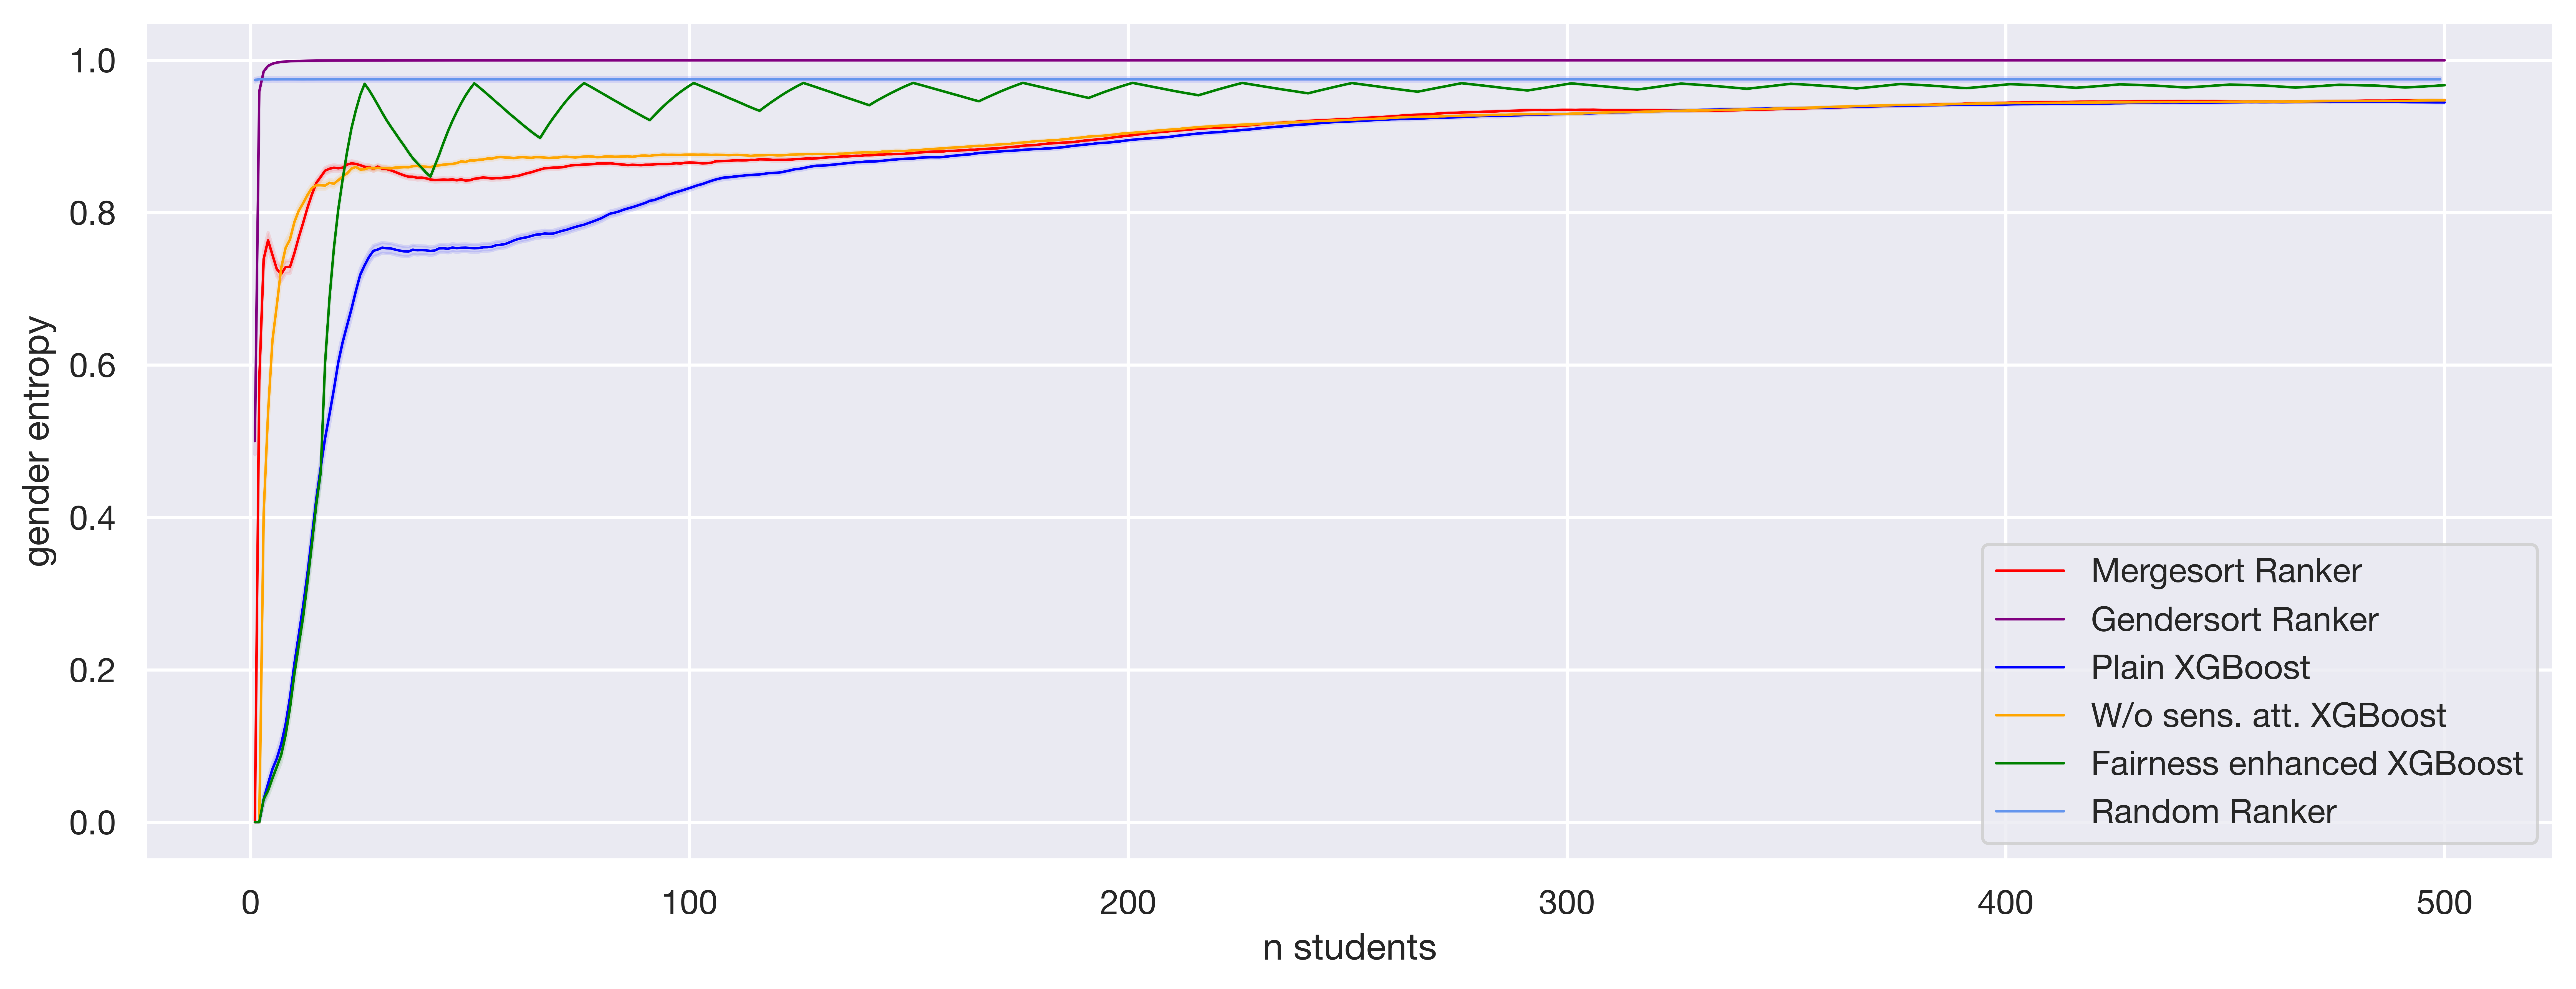

In [75]:
k=0
l=500


#Mergesort
sns.lineplot(data=df_sort_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[k:l], alpha=0.1, color="red")

#Gendersort
sns.lineplot(data=gender_df_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="purple", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[k:l], alpha=0.1, color="purple")

#Rankers
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="blue", linewidth=0.8) #lw=0.2
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], alpha=0.1, color="blue")

sns.lineplot(data=df_wo_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[k:l], alpha=0.1, color="orange")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

#from "all rankers with random" - run below"
sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="blue")



plt.xlabel('n students')
plt.ylabel('gender entropy')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
# plt.title('Entropy of models - Gender, all rankers')
plt.legend(['Mergesort Ranker', 'Gendersort Ranker',"Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost", "Random Ranker"], loc ="lower right")

# plt.savefig('all_entropy.png')

plt.show()

### FAIR entropy: mean and CMA

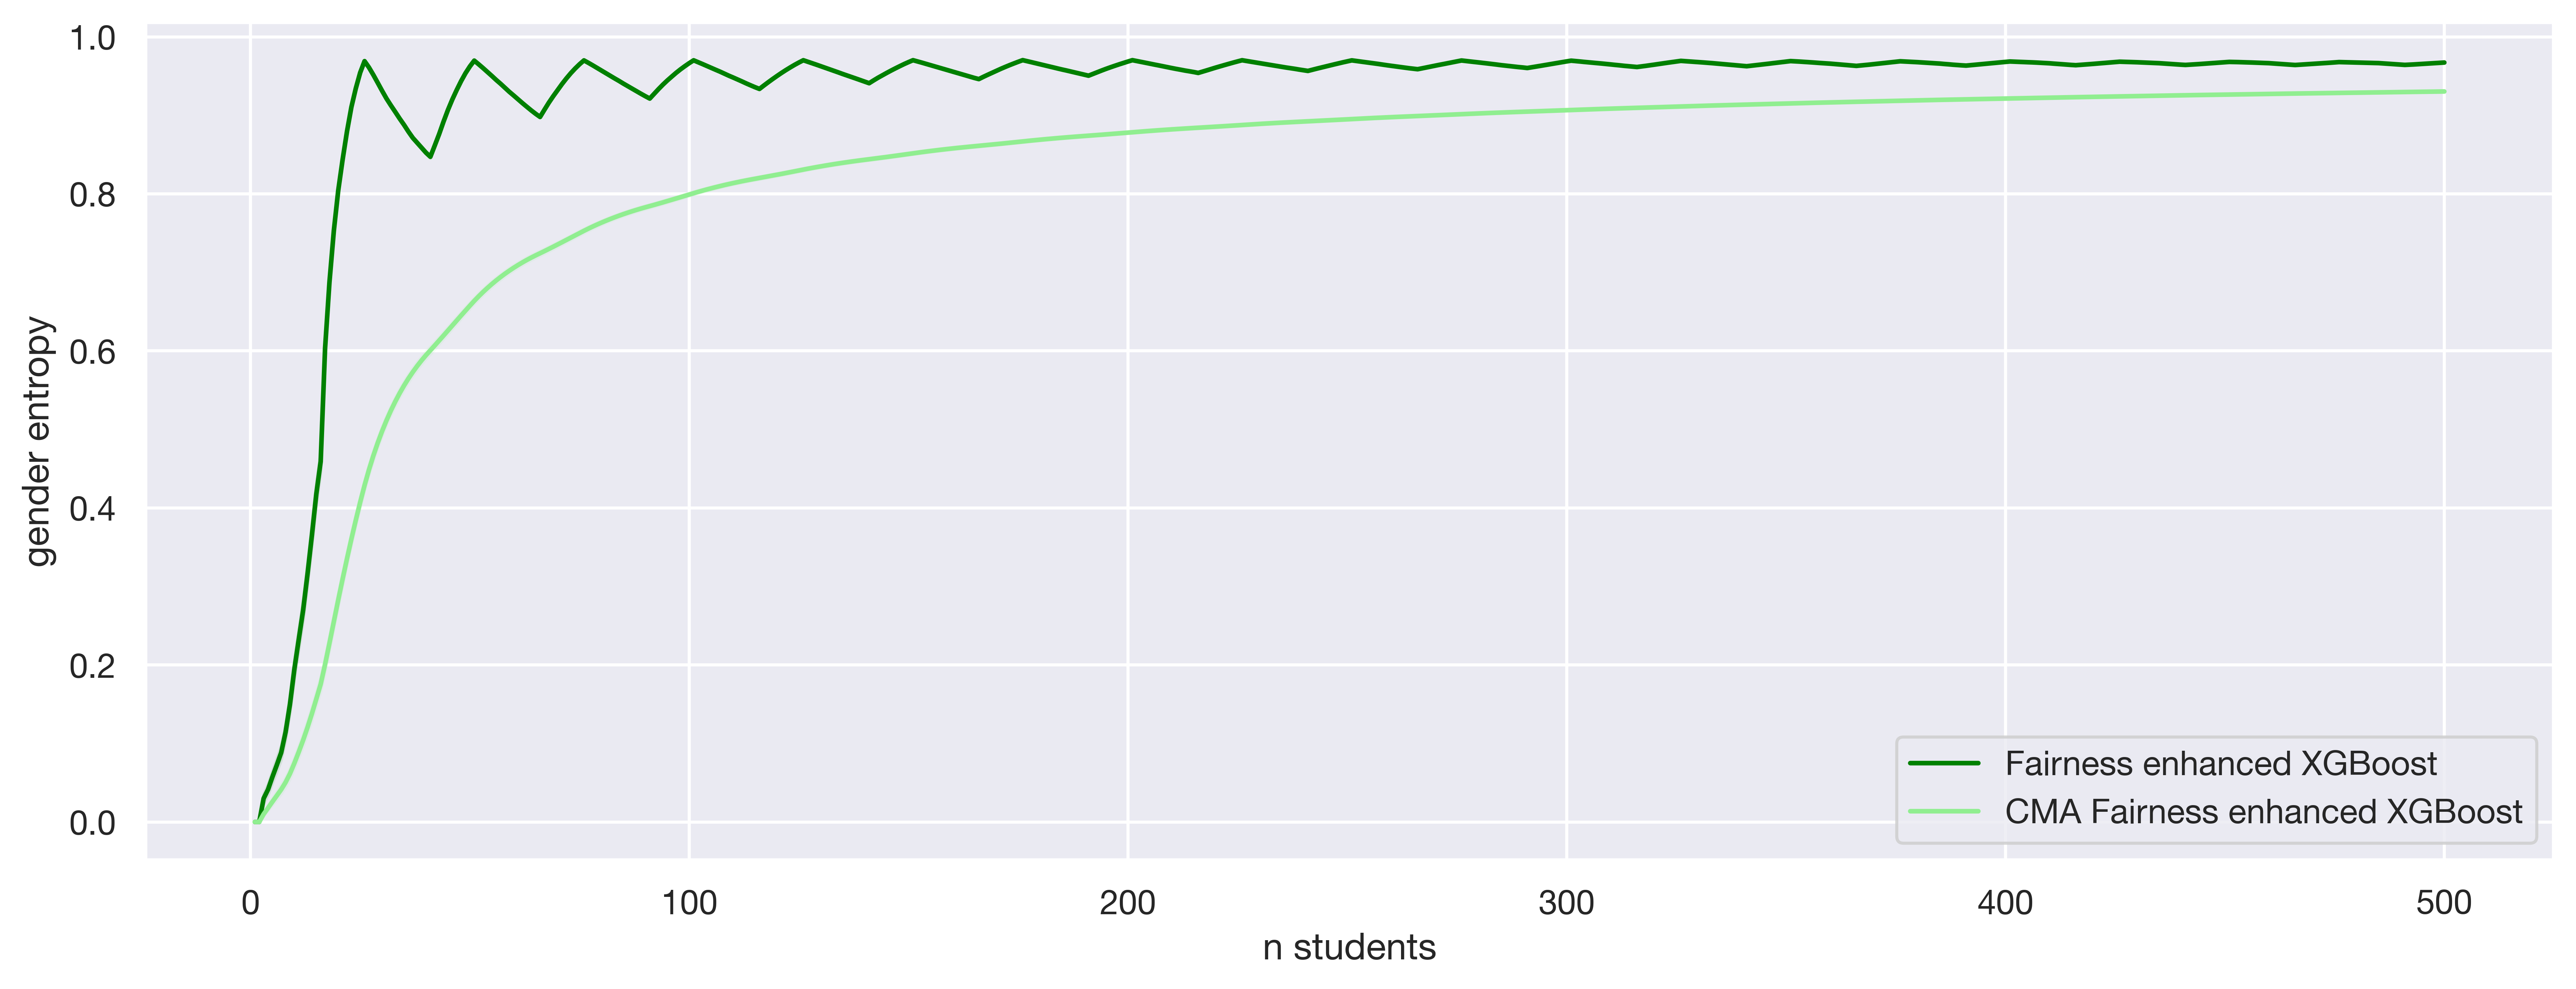

In [51]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost"], loc ="lower right")
plt.show()

### All rankers with random

In [52]:
## Random entropy

# #Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df_for_random.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin", "HI_GRADE_AVG"]] #"STRATUM"

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)

# # #The random df to use = df_random1


In [53]:
# #only take n students from index 1-500
indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()


In [54]:
# DENNE VIRKER!!!!

random_value_counts_GENDER = []
i = 0
while i < 999:
    idx = 0
    while idx <= df_random_use.n_students.max():
        random_value_counts_GENDER.append(np.array([df_random_use["GENDER_bin"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

In [55]:
df_random_use["value_counts_col_GENDER"] = random_value_counts_GENDER[1:]

In [56]:
#Entropy for each row

random_entropy_GENDER = []
for i in df_random_use.index:
    random_entropy_GENDER.append(-(df_random_use["value_counts_col_GENDER"][i]*np.log2(df_random_use["value_counts_col_GENDER"][i])).sum())    

In [57]:
df_random_use["entropy_col_GENDER"] = random_entropy_GENDER

In [58]:
df_random_use

index  Unnamed: 0  COL_GRADE_AVG  GENDER_bin  HI_GRADE_AVG  \
0         123        5945      32.333333           0     43.333333   
1        1283        9640      23.333333           1     45.000000   
2        2368        4049      81.666667           1     68.333333   
3        3981        1079      47.666667           1     52.333333   
4        1696        5462      80.666667           0     59.666667   
...       ...         ...            ...         ...           ...   
499494   3538       10314      69.333333           1     64.666667   
499495   3264       11747      67.333333           1     58.000000   
499496   3652        8739      31.333333           1     46.000000   
499497   2544        1366      57.666667           0     53.000000   
499498    398        3145      51.666667           0     57.666667   

        incr_col_mean  n_students  \
0           32.333333           1   
1           27.833333           2   
2           45.777778           3   
3           46.250000           4   
4           53.133333           5   
...               ...         ...   
499494      63.295623         495   
499495      63.303763         496   
499496      63.239437         497   
499497      63.228246         498   
499498      63.205077         499   

                            value_counts_col_GENDER  entropy_col_GENDER  
0                                           [[1.0]]           -0.000000  
1                                      [[0.5, 0.5]]            1.000000  
2        [[0.6666666666666666, 0.3333333333333333]]            0.918296  
3                                    [[0.75, 0.25]]            0.811278  
4                                      [[0.6, 0.4]]            0.970951  
...                                             ...                 ...  
499494   [[0.5737373737373738, 0.4262626262626263]]            0.984254  
499495   [[0.5745967741935484, 0.4254032258064516]]            0.983884  
499496  [[0.5734406438631791, 0.42655935613682094]]            0.984381  
499497  [[0.5742971887550201, 0.42570281124497994]]            0.984013  
499498  [[0.5731462925851704, 0.42685370741482964]]            0.984507  

[499499 rows x 9 columns]

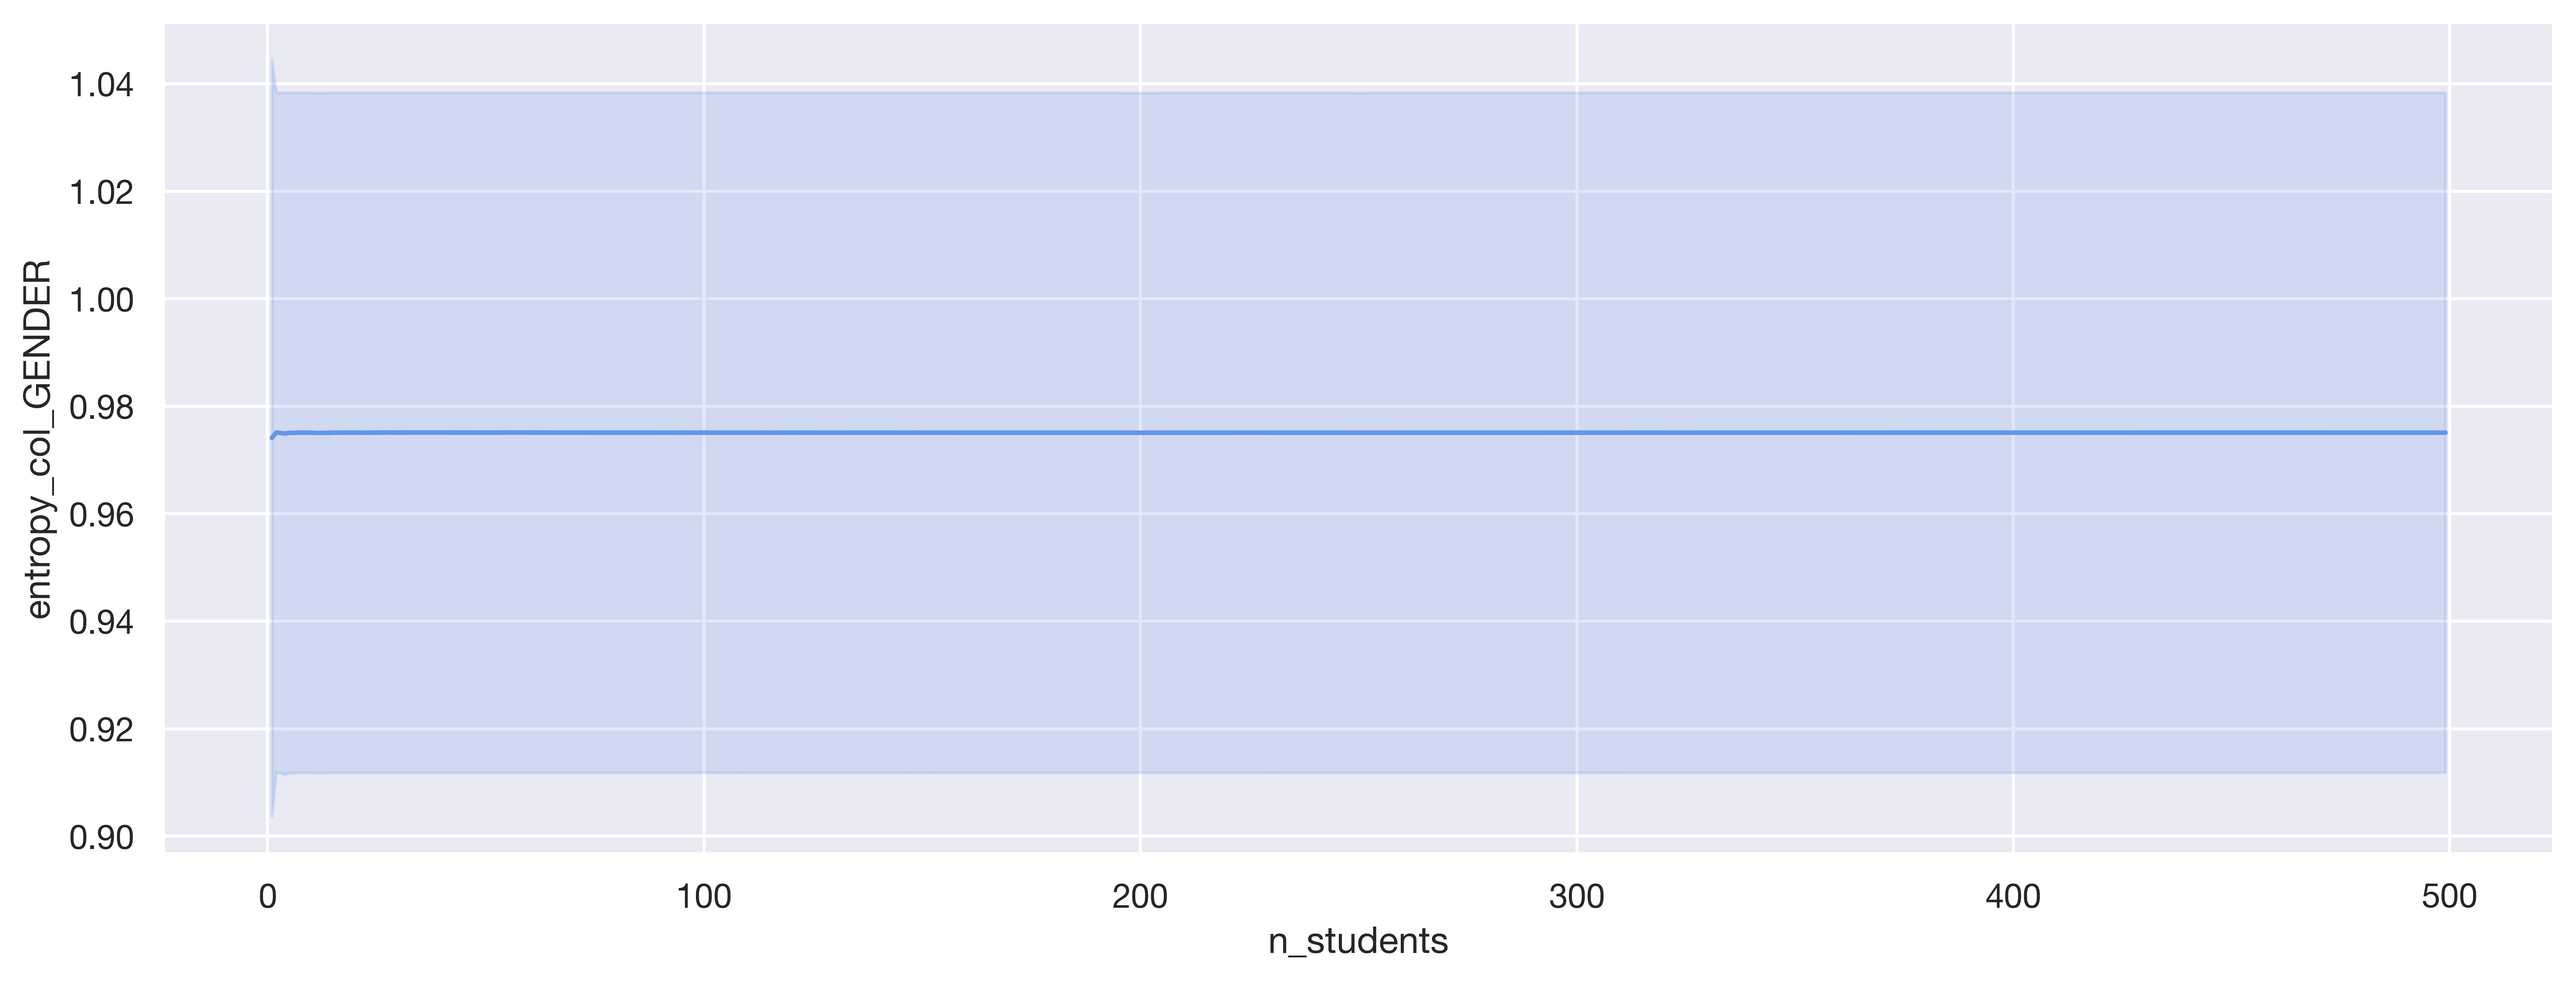

In [59]:
# random entropy gender

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#df_sort["n_students"] = range(len(df_sort))

sns.color_palette("deep")

# randomsort entropy of gender
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue")
plt.show()

In [60]:
#Mean evt cum


#Mean gender entropy
df_random_mean =  df_random_use.groupby('n_students').mean()
df_random_mean["incr_col_entropy"] = df_random_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
df_random_BIG_std = df_random_use.groupby('n_students').std()/np.sqrt(200)
df_random_BIG_std["incr_col_entropy"] = df_random_use['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_random_mean["incr_half_std"] = 0.5*df_random_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_random_mean["lower_std"] = df_random_mean["entropy_col_GENDER"] - df_random_mean["incr_half_std"]
df_random_mean["upper_std"] = df_random_mean["entropy_col_GENDER"] + df_random_mean["incr_half_std"]


#For cum
df_random_mean["incr_half_cum_std"] = 0.5*df_random_BIG_std["incr_col_entropy"] #0.5 of std to plot on both sides of mean
df_random_mean["lower_std_cum"] = df_random_mean["incr_col_entropy"] - df_random_mean["incr_half_cum_std"]
df_random_mean["upper_std_cum"] = df_random_mean["incr_col_entropy"] + df_random_mean["incr_half_cum_std"]



In [61]:
df_random_mean.reset_index()
df_random_mean.index.names = ['INDEXES']

In [62]:
df_random_mean["n_students"] = range(1,len(df_random_mean)+1)
df_random_mean

index   Unnamed: 0  COL_GRADE_AVG  GENDER_bin  HI_GRADE_AVG  \
INDEXES                                                                      
1        1999.227772  6040.753247      62.402597    0.392607     60.777556   
2        1995.516484  6175.805195      63.727939    0.397602     61.823177   
3        2008.606394  6209.129870      63.602398    0.428571     61.327672   
4        2047.900100  6191.264735      64.180153    0.404595     61.321012   
5        2073.551449  6316.455544      63.256410    0.414585     61.045288   
...              ...          ...            ...         ...           ...   
495      2034.410589  6025.112887      63.822178    0.413586     61.159840   
496      2081.026973  6223.956044      62.504163    0.427572     60.860140   
497      2058.718282  6234.222777      63.236430    0.384615     61.444555   
498      2029.604396  6504.496503      61.977023    0.408591     60.681985   
499      2050.804196  6475.208791      61.805861    0.410589     60.526474   

         incr_col_mean  entropy_col_GENDER  incr_col_entropy  incr_half_std  \
INDEXES                                                                       
1            62.402597            0.974114          0.974114       0.002488   
2            63.065268            0.975113          0.974613       0.002237   
3            63.244311            0.975031          0.974752       0.002238   
4            63.478272            0.974924          0.974795       0.002244   
5            63.433899            0.975084          0.974853       0.002237   
...                ...                 ...               ...            ...   
495          62.988266            0.975097          0.975090       0.002237   
496          62.987290            0.975096          0.975090       0.002237   
497          62.987791            0.975097          0.975090       0.002237   
498          62.985761            0.975097          0.975090       0.002237   
499          62.983397            0.975097          0.975090       0.002237   

         lower_std  upper_std  incr_half_cum_std  lower_std_cum  \
INDEXES                                                           
1         0.971626   0.976602           0.250000       0.724114   
2         0.972876   0.977349           0.319716       0.654897   
3         0.972793   0.977268           0.341197       0.633556   
4         0.972680   0.977168           0.370052       0.604743   
5         0.972847   0.977320           0.384902       0.589951   
...            ...        ...                ...            ...   
495       0.972860   0.977334           0.488499       0.486591   
496       0.972860   0.977333           0.488506       0.486583   
497       0.972860   0.977334           0.488513       0.486576   
498       0.972860   0.977333           0.488521       0.486569   
499       0.972860   0.977334           0.487544       0.487546   

         upper_std_cum  n_students  
INDEXES                             
1             1.224114           1  
2             1.294329           2  
3             1.315949           3  
4             1.344848           4  
5             1.359755           5  
...                ...         ...  
495           1.463589         495  
496           1.463596         496  
497           1.463603         497  
498           1.463611         498  
499           1.462633         499  

[499 rows x 15 columns]

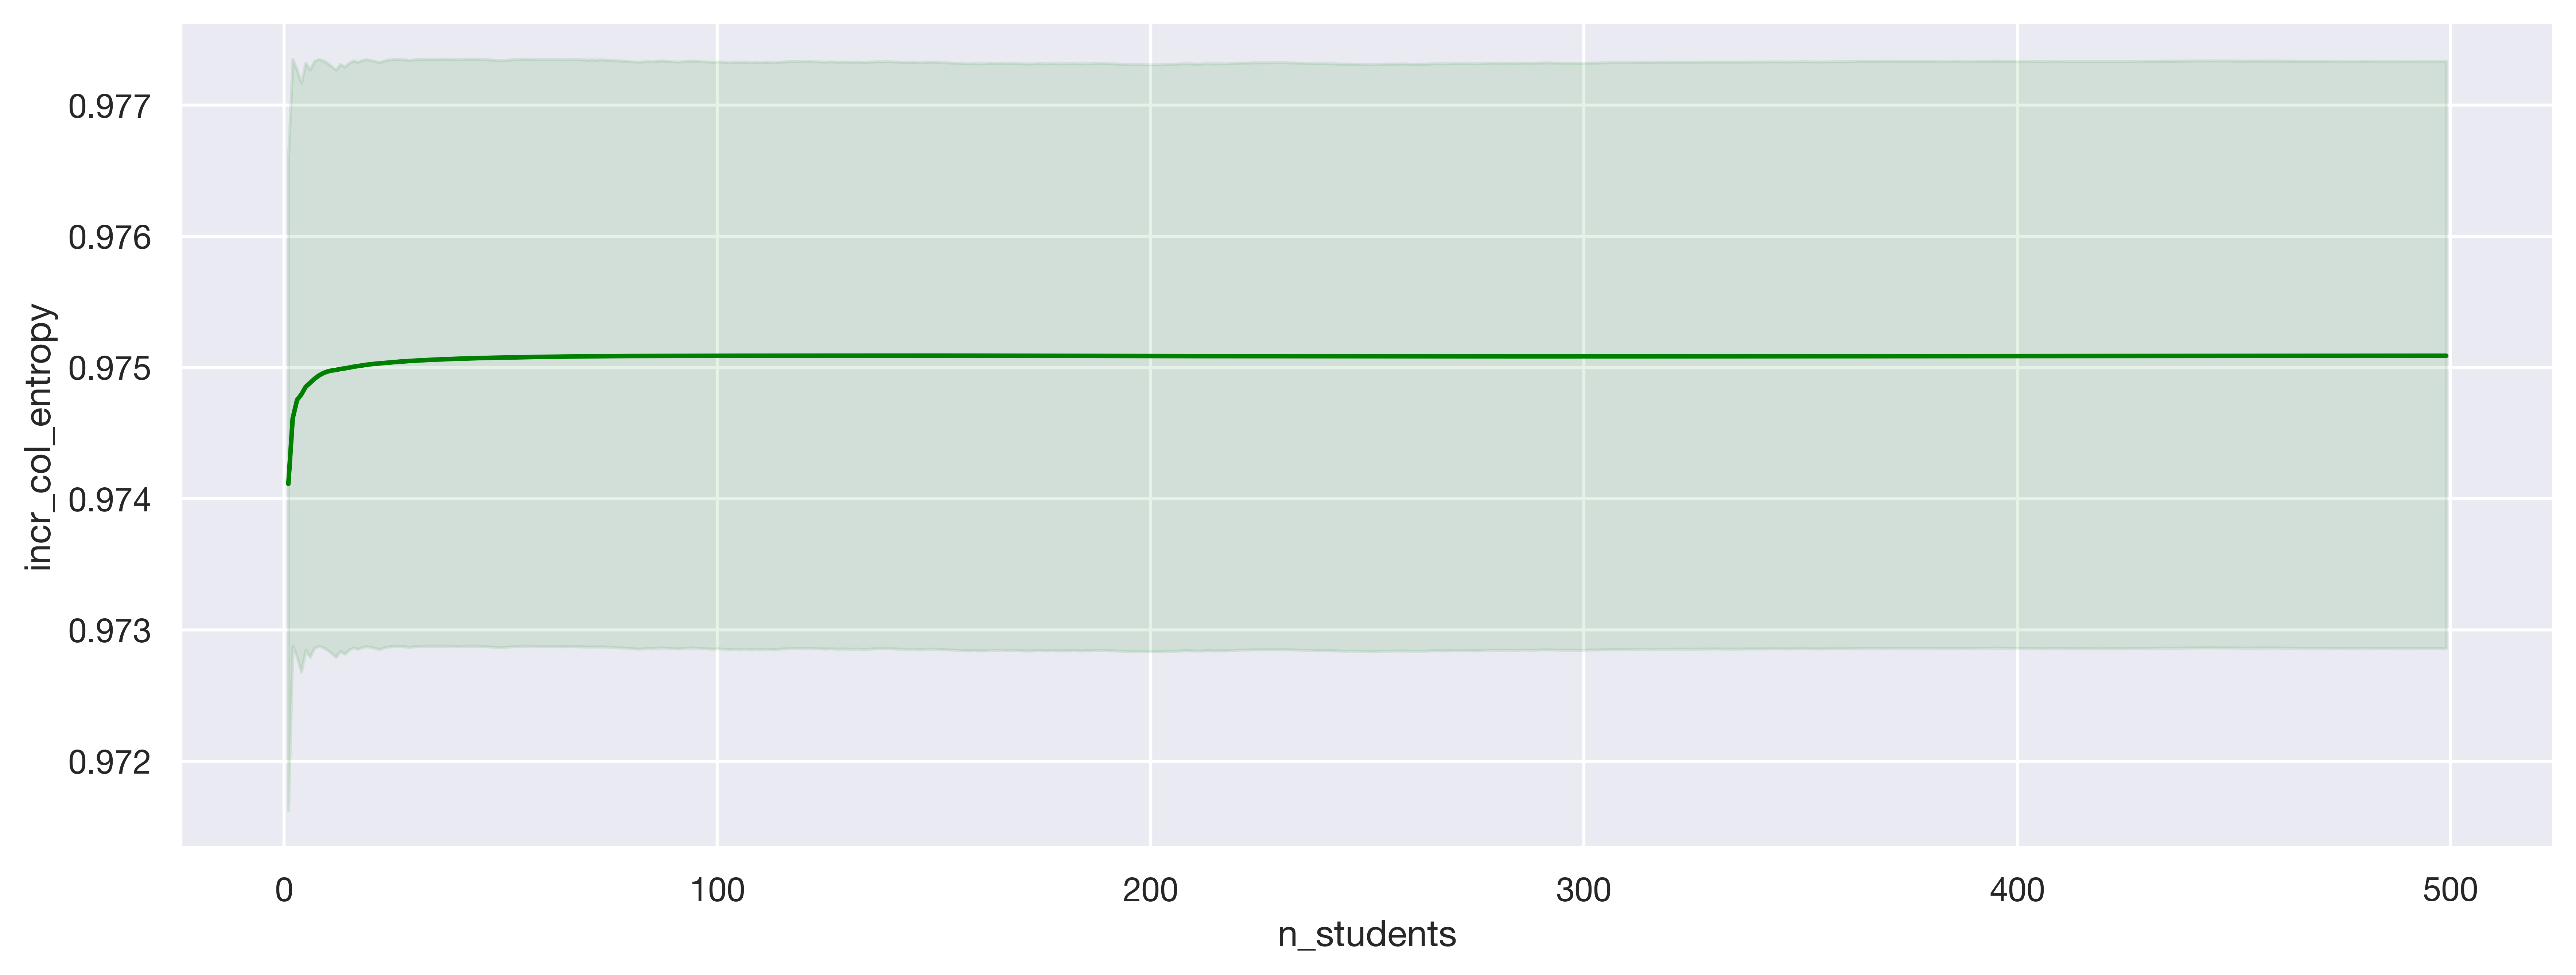

In [63]:
sns.lineplot(data=df_random_mean, x="n_students", y="incr_col_entropy",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="green")



plt.show()

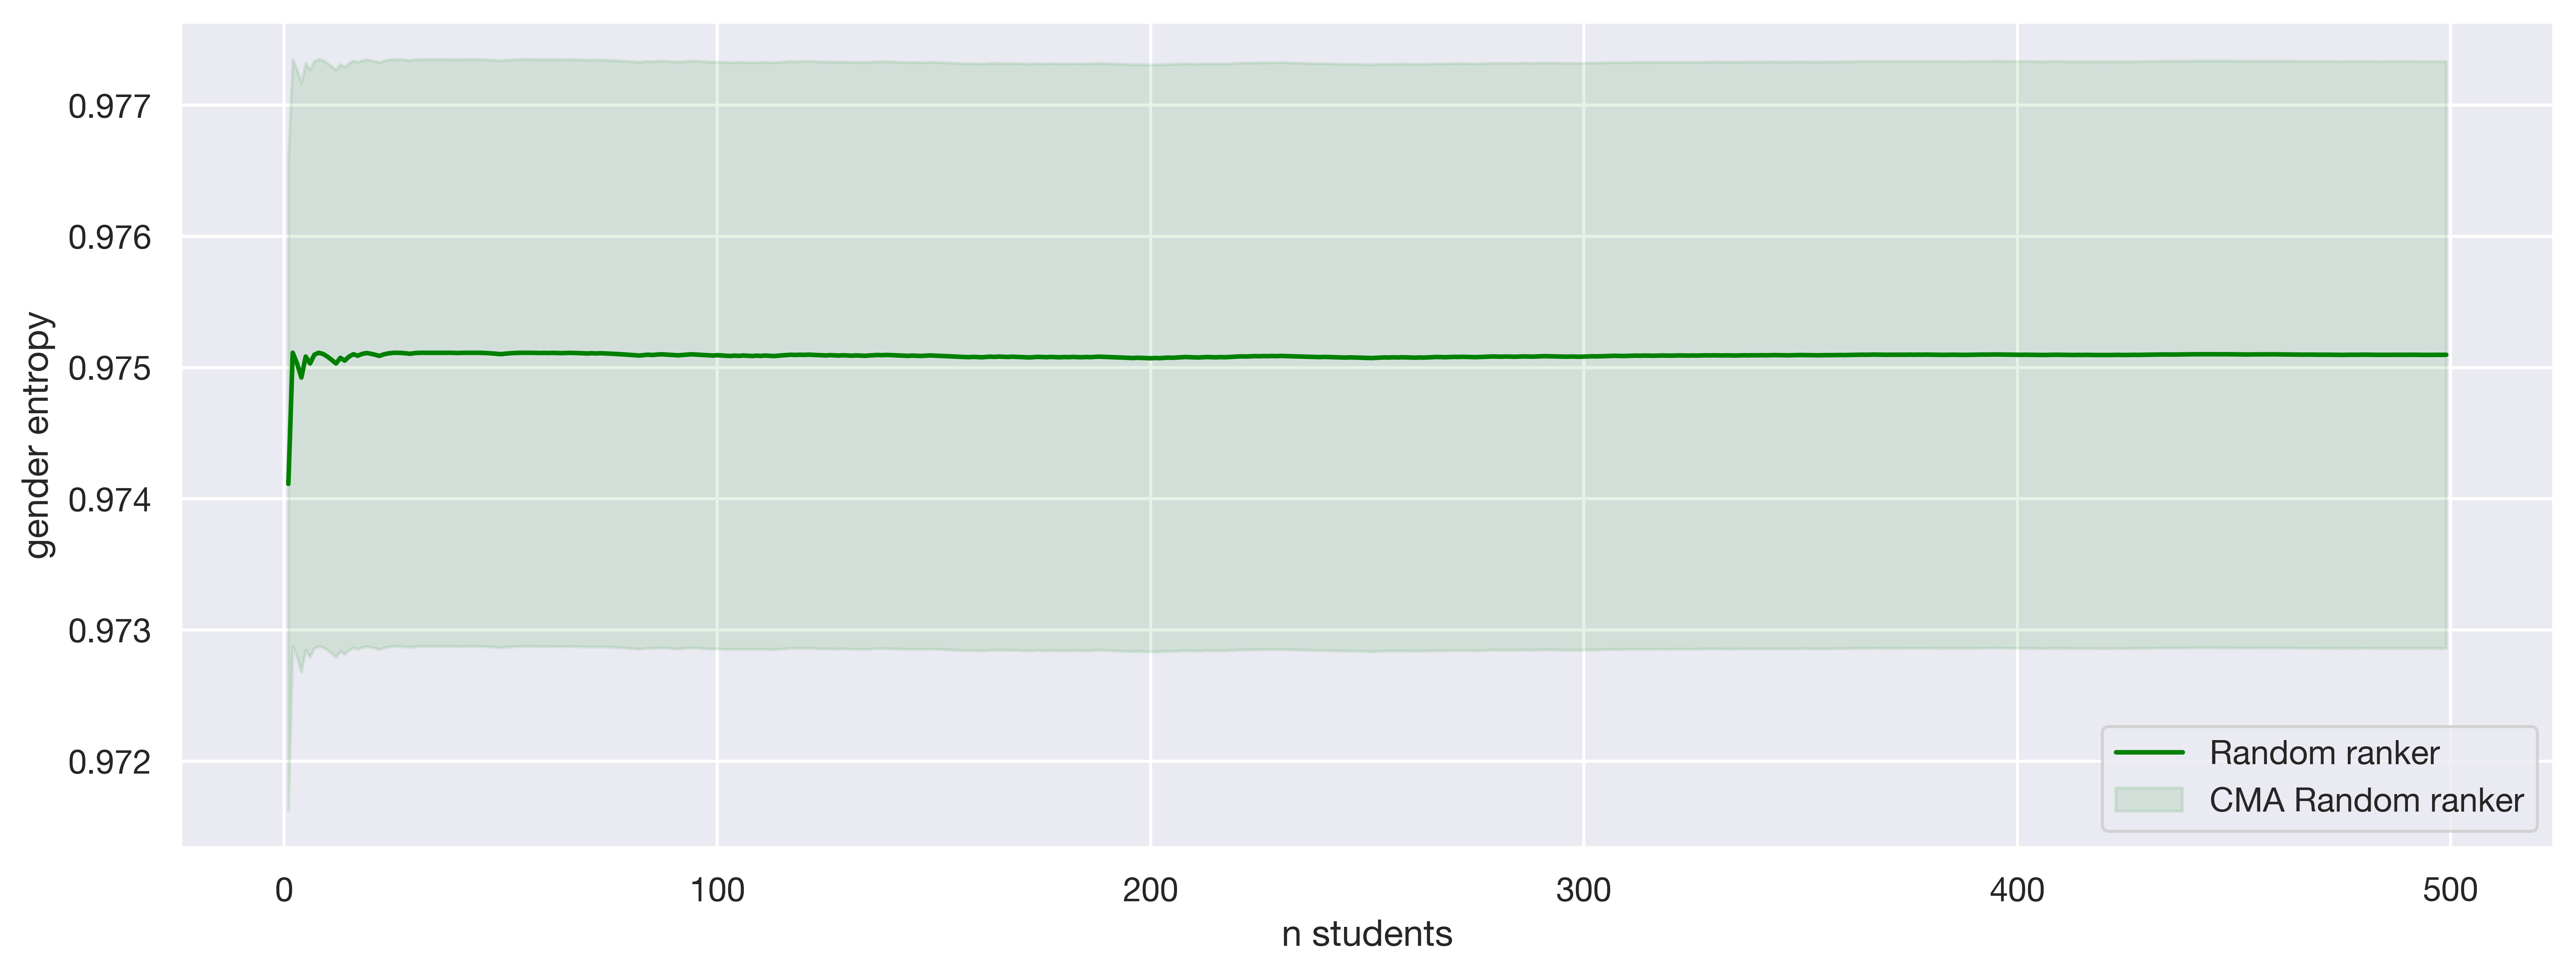

In [64]:
sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="green")

#sns.lineplot(data=df_random_mean, x="n_students", y="incr_col_entropy",  color="lightgreen", ci="sd")
#plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data= df_random_mean, alpha=0.1, color="green")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Random ranker", "CMA Random ranker"], loc ="lower right")
plt.show()

## FAIR and random/GT

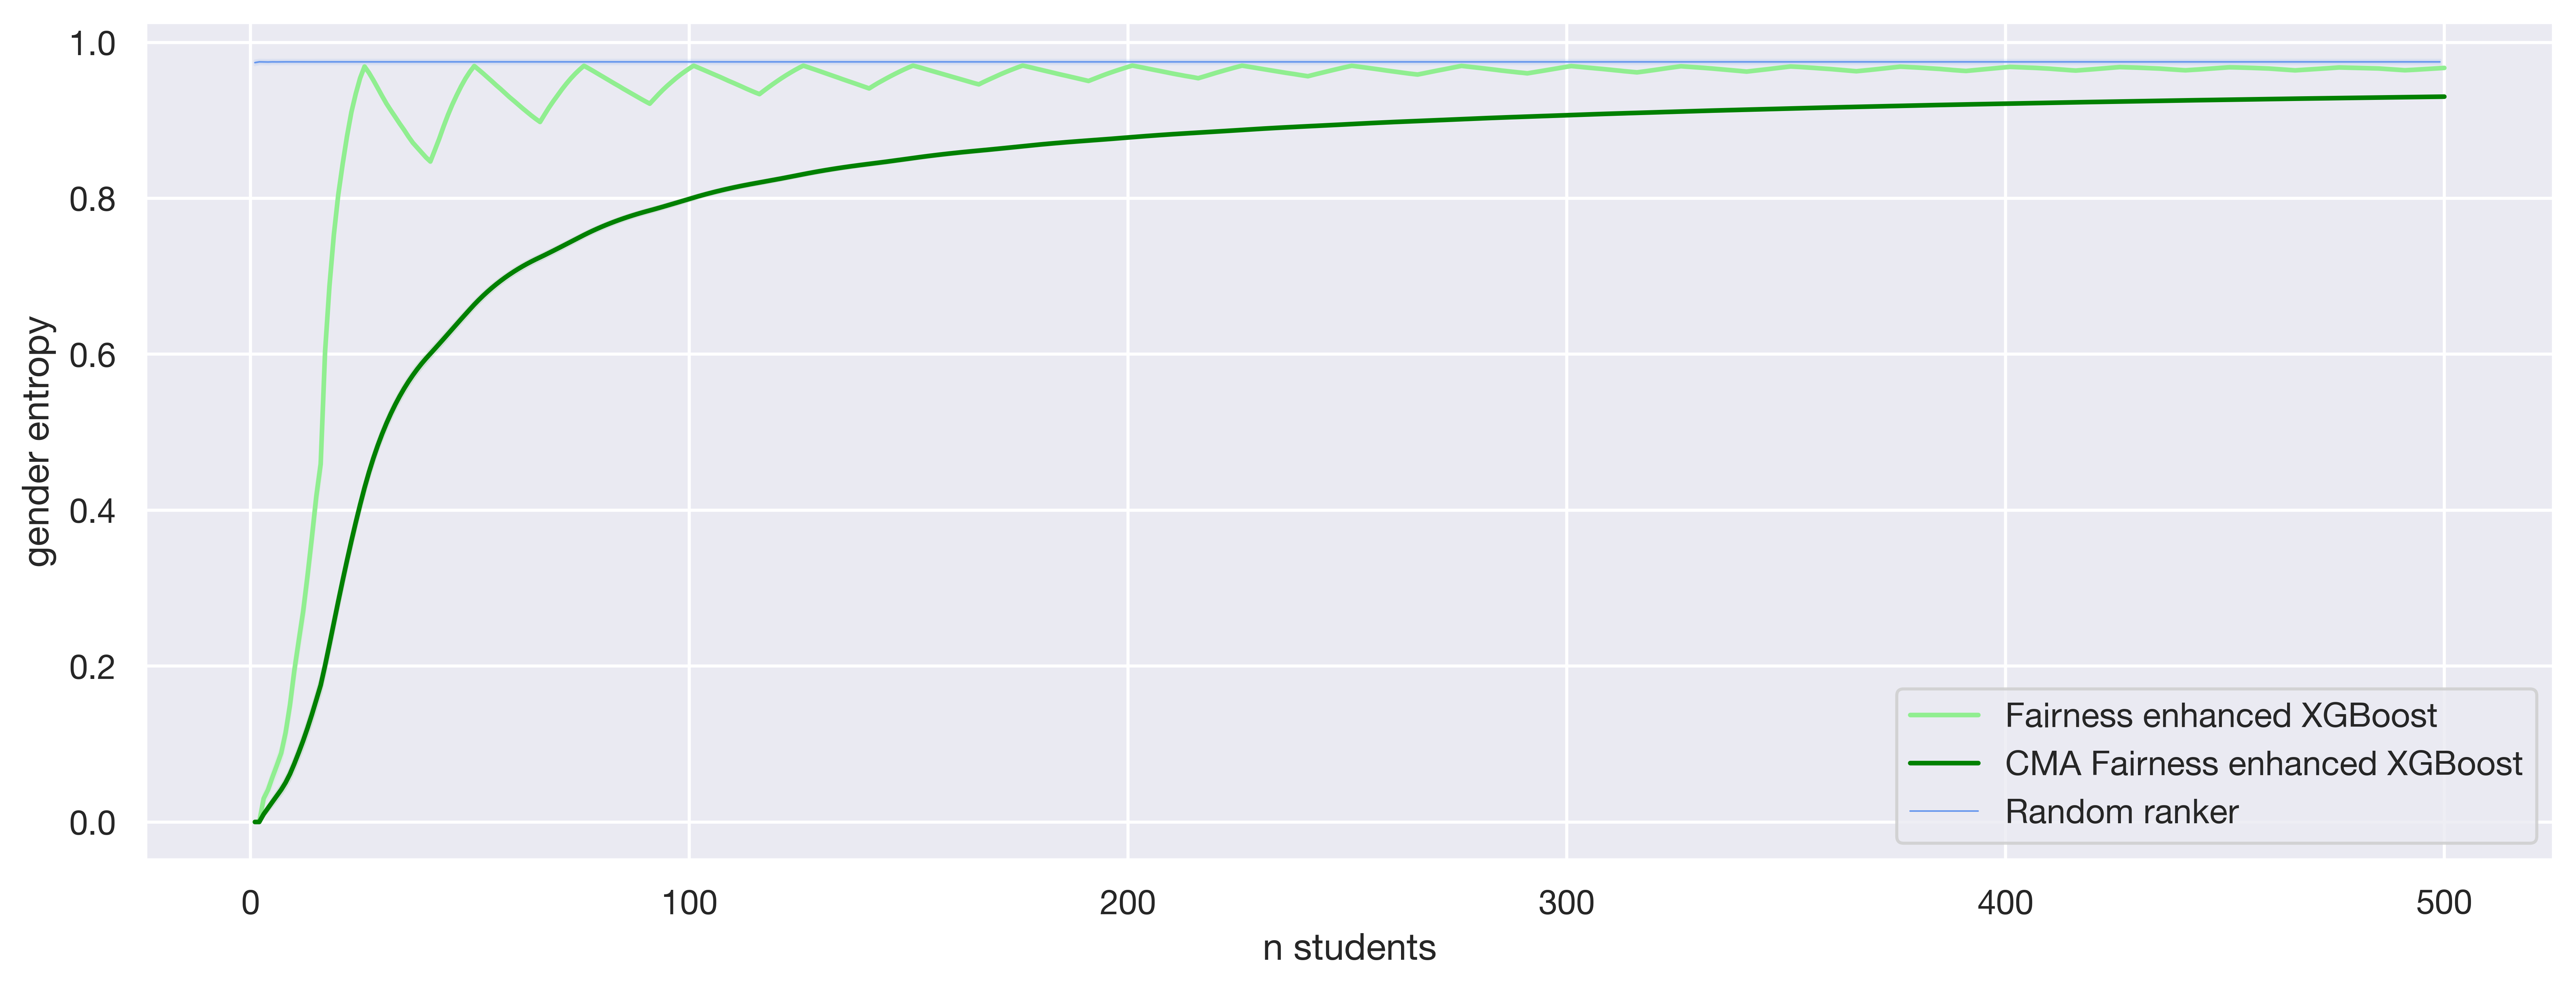

In [65]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")


sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="cornflowerblue")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost", "Random ranker"], loc ="lower right")
plt.show()

In [66]:
GT_df = pd.read_csv("GT.csv")

GUDF_df = pd.read_csv("GUDF.csv") 

GT_df = GT_df.merge(GUDF_df[["GENDER_bin", "Unnamed: 0"]], on="Unnamed: 0", how='left')

# Reset index of GT 
GT_df = GT_df.reset_index()
#For each row incremented, get ratio of M and F
data_value_counts_gen = []
for i in range(1,len(GT_df)+1):
    data_value_counts_gen.append(np.array([GT_df["GENDER_bin"][:i].value_counts(normalize=True)]))
#Create new column with the ratios
GT_df["value_counts_col_GENDER"] = data_value_counts_gen
#For each row incremented, get entropy 
data_entropy = []
for i in range(len(GT_df)):
    data_entropy.append(-(GT_df["value_counts_col_GENDER"][i]*np.log2(GT_df["value_counts_col_GENDER"][i])).sum())
#Create new column with the entropy
GT_df["entropy_col_GENDER"] = data_entropy

GT_df

print("Gender entropy for whole GT:", GT_df.entropy_col_GENDER[-1:].values)




Gender entropy for whole GT: [0.97554731]


In [77]:
#UTILITY GROUND TRUTH
print("utility gt: ", GT_df.y_test.mean())

utility gt:  63.04573567708337


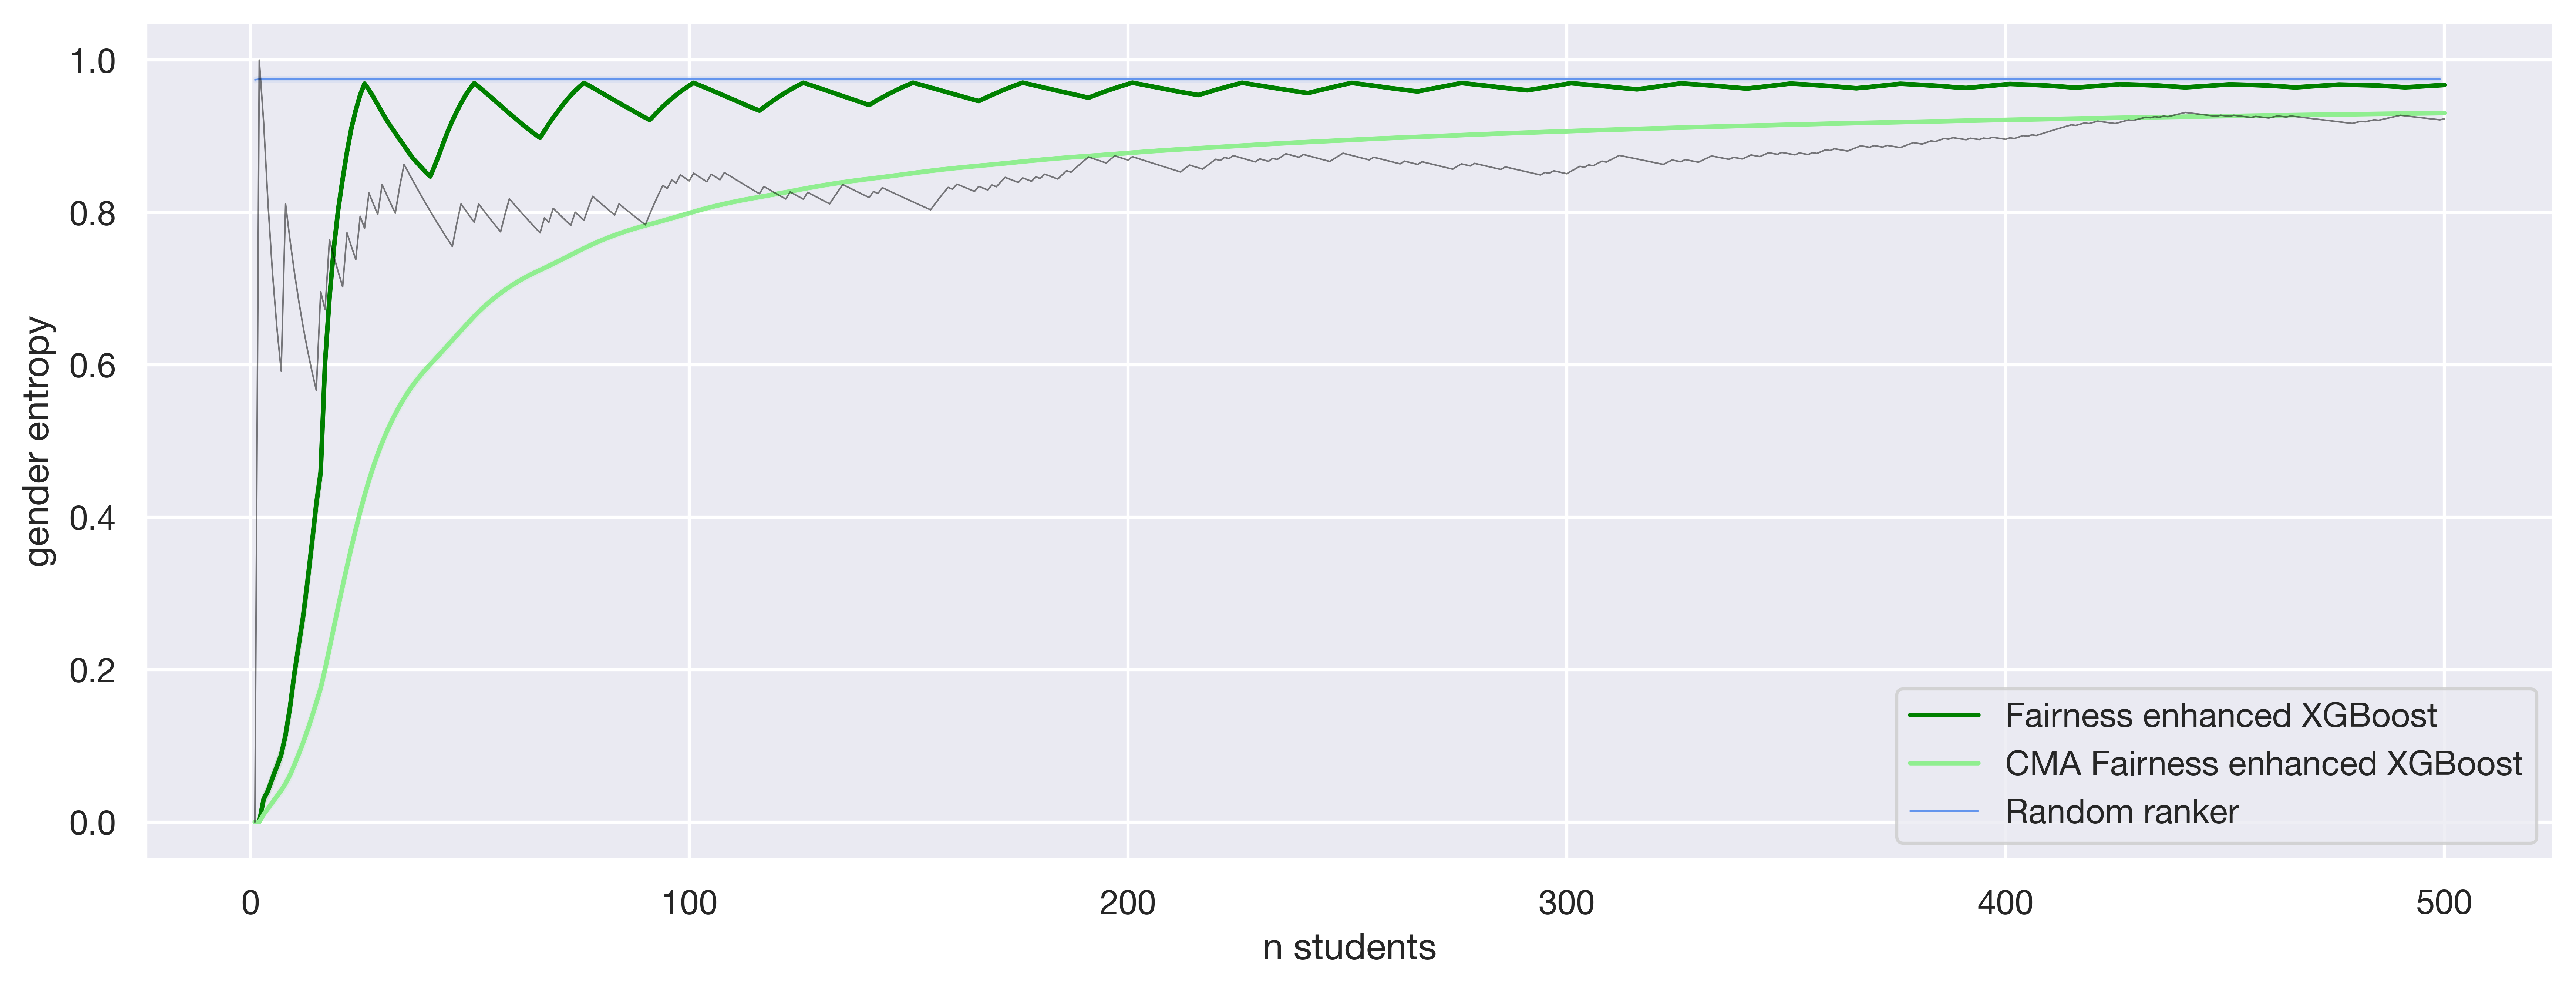

In [67]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")


sns.lineplot(data=df_random_mean, x="n_students", y="entropy_col_GENDER",  color="cornflowerblue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_mean, alpha=0.1, color="cornflowerblue")


GT_df['n_students'] = range(1,len(GT_df)+1)
sns.lineplot(data=GT_df[:500], x="n_students", y="entropy_col_GENDER",  color="black", ci="sd", linewidth=0.5, alpha=0.5)


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost", "Random ranker"], loc ="lower right")
plt.show()
